In [61]:
# This Notebook is the 'Walk-through' Guide for replicating
# the results in arXiv:2506.20622:  'Modeling Behavioral Traits 
# as Dynamical Systems: Entropy-based Analysis of Longitudinal 
# Psychometric Data with Coupled Ordinary Differential Equations'
# by Anderson M. Rodriguez
#
# Entropy is extracted from the dataset, then fed into a series of
# recursively interacting ODEs which were designed with ecosystem 
# constraints in mind. The driven entropy signal is compartively
# forward-simulated against the empirical entropy signal.


In [63]:
#This repository uses publicly available data derived from the Swedish Adoption/Twin Study of Aging (SATSA), provided by 
#the Inter-university Consortium for Political and Social Research (ICPSR). 
#The data are licensed for secondary use and analysis. 
#Accessed via [ICPSR #4538](https://doi.org/10.3886/ICPSR03843.v2).
#
#Citation:
#Pedersen, Nancy L. Swedish Adoption/Twin Study on Aging (SATSA), 1984, 1987, 1990, 1993, 2004, 2007, and 2010. 
#Inter-university Consortium for Political and Social Research [distributor], 2015-05-13.

In [65]:
#Example of Raw psychometric data from SATSA:
#
#Trait Proxy: A1: I want to be the best in everything
#Year: 1984
#1 exactly right 78 
#2 almost right 190 
#3 neither right nor wrong 318 
#4 not quite right 501 
#5 not right at all 836
#
#Normalization is not done initially so as to avoid unnecessary dimensional reduction
#ahead of the entropy conversion.

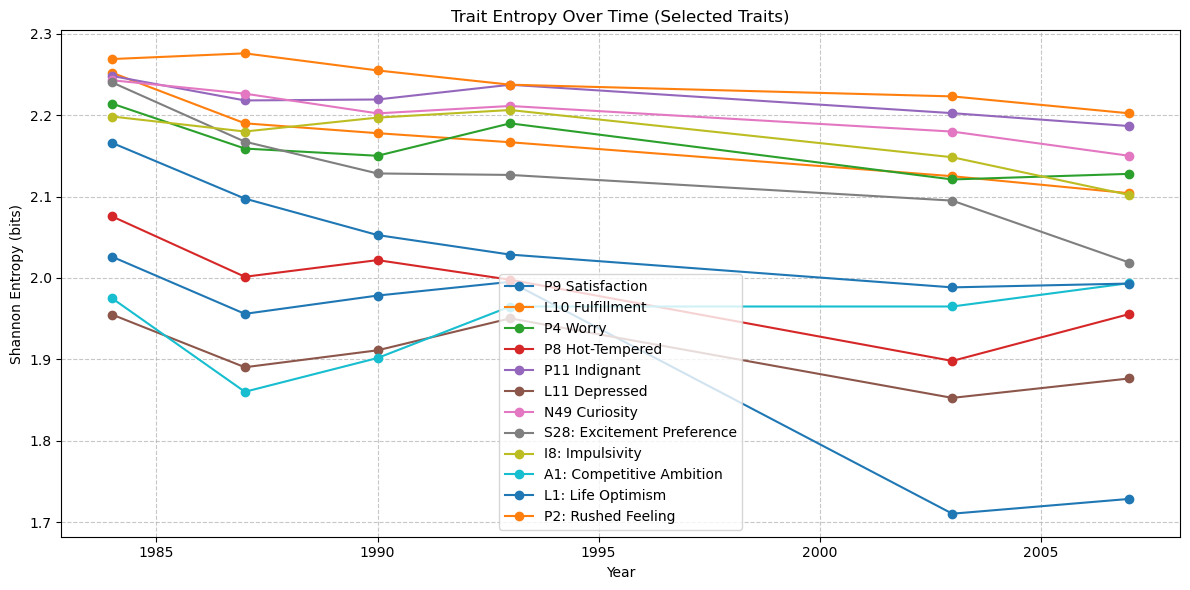

Trait                     Year    Entropy
P9 Satisfaction           1984     2.0260
P9 Satisfaction           1987     1.9559
P9 Satisfaction           1990     1.9783
P9 Satisfaction           1993     1.9952
P9 Satisfaction           2003     1.7102
P9 Satisfaction           2007     1.7284
L10 Fulfillment           1984     2.2521
L10 Fulfillment           1987     2.1900
L10 Fulfillment           1990     2.1779
L10 Fulfillment           1993     2.1668
L10 Fulfillment           2003     2.1250
L10 Fulfillment           2007     2.1041
P4 Worry                  1984     2.2142
P4 Worry                  1987     2.1590
P4 Worry                  1990     2.1501
P4 Worry                  1993     2.1900
P4 Worry                  2003     2.1210
P4 Worry                  2007     2.1279
P8 Hot-Tempered           1984     2.0755
P8 Hot-Tempered           1987     2.0014
P8 Hot-Tempered           1990     2.0219
P8 Hot-Tempered           1993     1.9978
P8 Hot-Tempered           2003    

In [67]:
# MODULE 1
# Associated with 'Figure 1', 'Figure 2', and 'Figure 3' in arXiv:2506.20622
#
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Define Likert-scale trait frequency data (as in the main model)
# Each list contains 5 Likert bin counts per year, from 1 (highest agreement) to 5 (lowest agreement)
# So, 1: exactly Right; 2. almost right; 3. neither right nor wrong; 4. not quite right; 5. not right at all
# The years are: 1984, 1987, 1990, 1993, 2003, 2007:

trait_data = {
    "P9 Satisfaction": [
        [76, 231, 294, 611, 698], #Row 1984: Likert scores 1 → 5
        [48, 146, 248, 523, 593], #Row 1987: Same structure throughout
        [40, 125, 288, 480, 489], #Row 1990
        [29, 158, 289, 447, 480], #Row 1993
        [92, 443, 156, 68, 15],   #Row 2003
        [85, 354, 138, 40, 17]    #Row 2007
    ],
    "L10 Fulfillment": [
        [193, 348, 445, 539, 382],
        [114, 252, 448, 447, 291],
        [106, 230, 423, 424, 240],
        [92, 212, 461, 344, 290],
        [40, 110, 239, 235, 149],
        [25, 95, 197, 189, 126]
    ],
    "P4 Worry": [
        [159, 374, 325, 548, 527],
        [95, 241, 300, 476, 448],
        [74, 229, 309, 455, 359],
        [85, 250, 316, 391, 364],
        [29, 133, 175, 250, 185],
        [22, 113, 171, 179, 144]
    ],
    "P8 Hot-Tempered": [
        [124, 249, 287, 473, 780],
        [73, 162, 280, 360, 683],
        [60, 156, 254, 376, 576],
        [43, 179, 243, 350, 586],
        [12, 75, 137, 214, 335],
        [17, 59, 119, 178, 259]
    ],
    "P11 Indignant": [
        [185, 457, 334, 524, 415],
        [114, 332, 312, 448, 345],
        [101, 337, 329, 381, 280],
        [112, 353, 305, 344, 289],
        [53, 163, 204, 217, 139],
        [38, 139, 166, 176, 109]
    ],
    "L11 Depressed": [
        [103, 159, 269, 527, 855],
        [54, 105, 251, 450, 700],
        [38, 98, 263, 464, 563],
        [40, 114, 265, 453, 535],
        [13, 52, 135, 253, 323],
        [9, 43, 127, 200, 246]
    ],
    "N49 Curiosity": [
        [229, 520, 295, 310, 218],
        [116, 371, 402, 346, 287],
        [97, 343, 401, 319, 237],
        [99, 327, 385, 334, 245],
        [44, 196, 207, 189, 125],
        [31, 164, 193, 136, 103]
    ],
    "S28: Excitement Preference": [
        [168, 408, 514, 468, 348],
        [107, 365, 502, 360, 211],
        [94, 343, 505, 309, 168],
        [91, 341, 505, 285, 174],
        [38, 180, 287, 166, 101],
        [28, 140, 266, 128, 67]
    ],
    "I8: Impulsivity": [
        [189, 332, 263, 584, 556],
        [108, 241, 313, 457, 450],
        [110, 228, 294, 452, 343],
        [113, 236, 284, 437, 351],
        [46, 117, 181, 266, 165],
        [27, 84, 154, 214, 154]
    ],
    "A1: Competitive Ambition": [
        [78, 190, 318, 501, 836],
        [38, 98, 279, 455, 700],
        [34, 97, 292, 402, 600],
        [36, 131, 302, 368, 570],
        [16, 72, 184, 207, 297],
        [11, 67, 171, 170, 213]
    ],
    "L1: Life Optimism": [
        [278, 656, 515, 322, 156],
        [154, 444, 589, 238, 137],
        [117, 393, 569, 231, 112],
        [97, 363, 578, 264, 104],
        [36, 219, 316, 138, 63],
        [31, 156, 270, 121, 53]
    ],
    "P2: Rushed Feeling": [
        [337, 573, 274, 429, 312],
        [207, 435, 293, 368, 269],
        [149, 369, 310, 365, 237],
        [133, 411, 299, 327, 238],
        [54, 183, 185, 190, 162],
        [44, 146, 135, 191, 116]
    ],
}

years = [1984, 1987, 1990, 1993, 2003, 2007]

# Entropy extraction function:
def compute_entropy_per_year(freqs):
    entropies = []
    for year_data in freqs:
        dist = np.array(year_data, dtype=np.float64)
        dist /= dist.sum()  # Normalize
        entropies.append(entropy(dist, base=2))  # Shannon entropy, base 2
    return entropies

# Optional: visualize a few traits or all traits
if __name__ == "__main__":
    plt.figure(figsize=(12, 6))

    for trait in trait_data: #this will plot all traits
        e_vals = compute_entropy_per_year(trait_data[trait])
        plt.plot(years, e_vals, marker='o', label=trait)



    
    plt.title("Trait Entropy Over Time (Selected Traits)")
    plt.xlabel("Year")
    plt.ylabel("Shannon Entropy (bits)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Compute entropy per year per trait 
print(f"{'Trait':<25} {'Year':<6} {'Entropy':>8}")
print("=" * 42)

for trait, data in trait_data.items():
    for i, year_data in enumerate(data):
        probs = np.array(year_data) / np.sum(year_data)
        ent = entropy(probs, base=2)  # use base 2 for bits
        print(f"{trait:<25} {years[i]:<6} {ent:>8.4f}")


Manual Parameters:
mu = 0.00001, alpha =  0.00800, beta = 0.16031, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 0.00000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.4064
RMSE for P4 Worry: 0.2198
R² for P8 Hot-Tempered: -0.7206
R² for P4 Worry: 0.6118
Pearson r (N): 0.885 (p=0.019)
Pearson r (P): 0.805 (p=0.053)

DTW distance (N): 1.854
DTW distance (P): 0.712


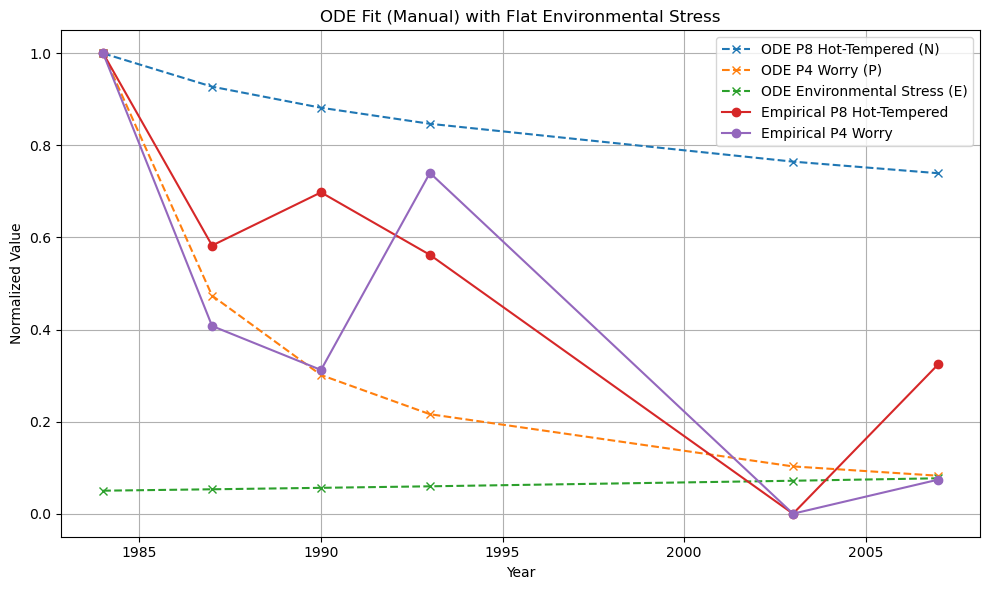

In [69]:
# MODULE 2a
# Associated with 'Figure 4' in in arXiv:2506.20622
#
# 'FIRST parameter Set'
# ECTO Nonlinear ODE System
#fixed alpha term display
#This script is FIXED E_stress
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System without Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8  #Not utilized when E left flat
    amplitude = 0.05 #Not utilized when E left flat
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) 
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.008
    beta  = 0.16031
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 0.0   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Flat Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Manual Parameters:
mu = 0.00001, alpha =  0.05300, beta = 0.16746, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 0.00000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.2117
RMSE for P4 Worry: 0.2205
R² for P8 Hot-Tempered: 0.5330
R² for P4 Worry: 0.6093
Pearson r (N): 0.886 (p=0.019)
Pearson r (P): 0.803 (p=0.054)

DTW distance (N): 0.834
DTW distance (P): 0.722


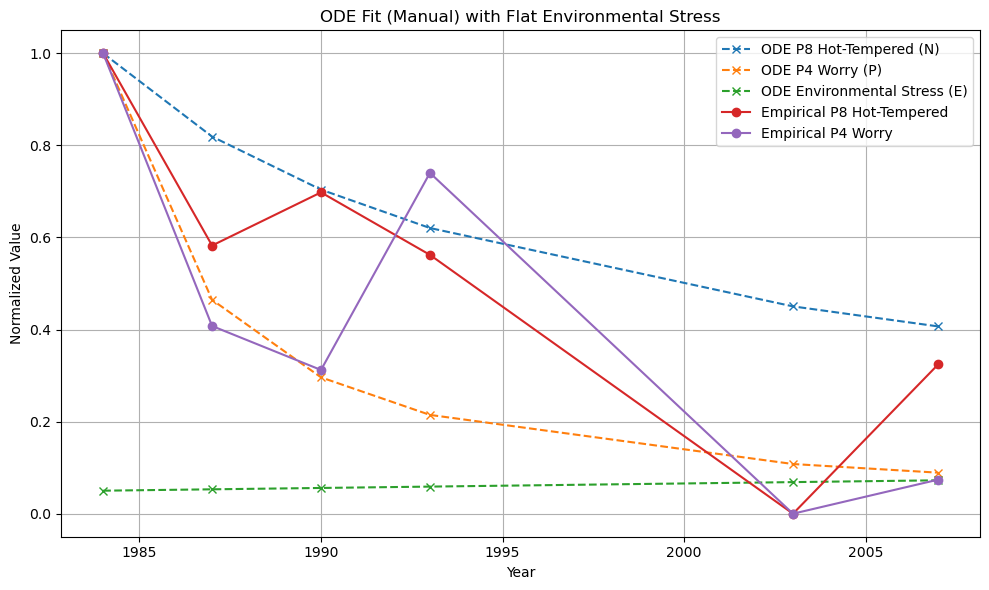

In [71]:
# MODULE 2b
# Associated with 'Figure 5' in in arXiv:2506.20622
#
# 'SECOND parameter Set'
# ECTO Nonlinear ODE System
#fixed alpha term display
#This script is FIXED E_stress
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System without Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) 
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.053
    beta  = 0.16746
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 0.0   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Flat Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Manual Parameters:
mu = 0.00001, alpha =  0.09800, beta = 0.17117, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 0.00000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.1552
RMSE for P4 Worry: 0.2205
R² for P8 Hot-Tempered: 0.7491
R² for P4 Worry: 0.6095
Pearson r (N): 0.879 (p=0.021)
Pearson r (P): 0.803 (p=0.055)

DTW distance (N): 0.648
DTW distance (P): 0.725


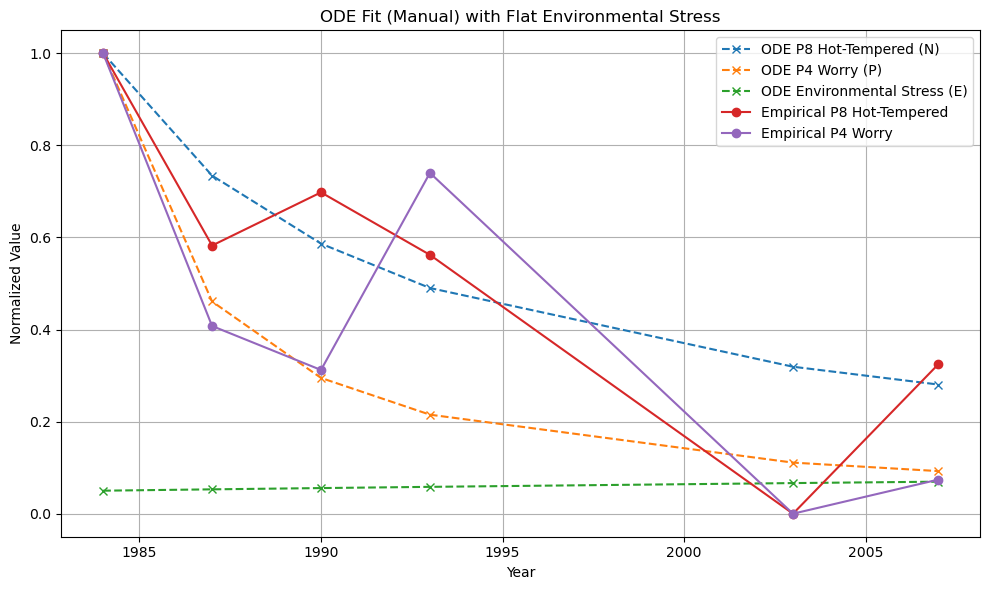

In [73]:
# MODULE 2c
# Associated with 'Figure 6' in in arXiv:2506.20622
#
# 'THIRD parameter Set'
# ECTO Nonlinear ODE System
#fixed alpha term display
#This script is FIXED E_stress
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System without Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8 #incosequential with Flat E
    amplitude = 0.05 #inconsequential with Flat E
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) 
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.098
    beta  = 0.17117
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 0.0   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Flat Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Manual Parameters:
mu = 0.00001, alpha =  0.09800, beta = 0.17117, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 12.60000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.1590
RMSE for P4 Worry: 0.2915
R² for P8 Hot-Tempered: 0.7367
R² for P4 Worry: 0.3176
Pearson r (N): 0.880 (p=0.021)
Pearson r (P): 0.777 (p=0.069)

DTW distance (N): 0.655
DTW distance (P): 0.783


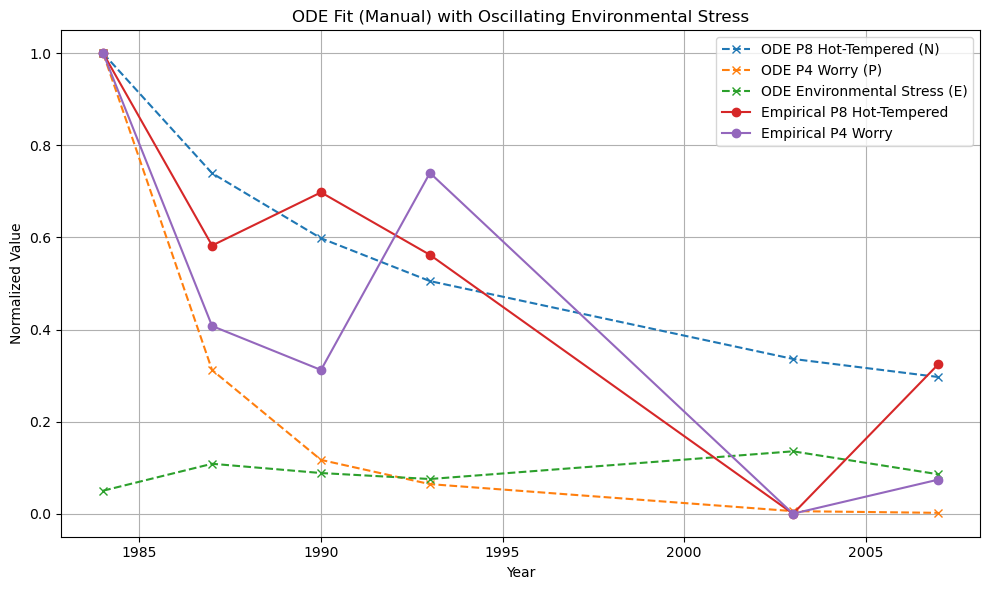

In [75]:
# MODULE 2d
# Associated with 'Figure 7' in in arXiv:2506.20622
#
#This script is OSCILLATORY E_stress
# 'FOURTH PARAMETER SET'
# ECTO Nonlinear ODE System
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System with Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, beta, alpha, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 0.8), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = 0.098
    beta  = 0.17117
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 012.60   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Oscillating Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


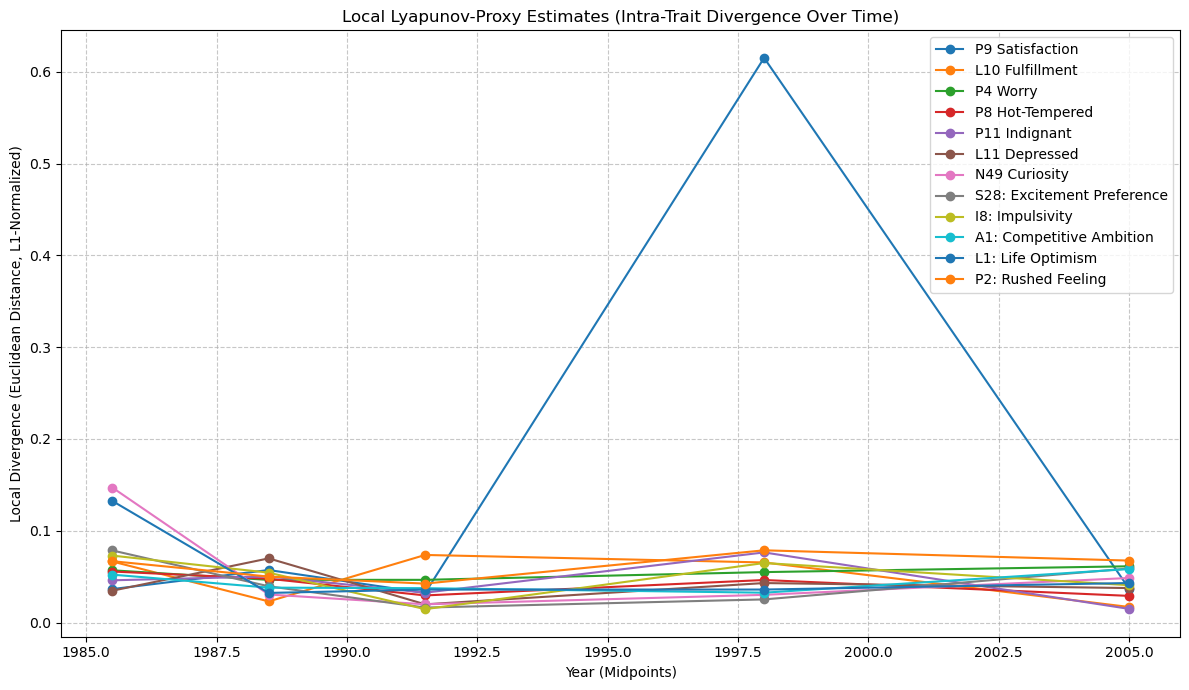

In [77]:
# MODULE 3a
# Associated with 'Figure 8' in in arXiv:2506.20622
#
# Appendix A.1: Trait Divergence:
#
# For orthogonal validation that the psychometric ecosystem is considerable as lawfully dynamical
# Lyapunov exponent-like analysis (Lyapunov proxy) was run, as explained 
# in the Appendix A.1 from Rodriguez 2025:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Define years and midpoints
years = [1984, 1987, 1990, 1993, 2003, 2007]
mid_years = [(years[i] + years[i+1]) / 2 for i in range(len(years) - 1)]

# Trait frequency data for Likert-scale (1–5) responses left to right (1, least agreed, on left)
# Years top to bottom (1984 top)
trait_data = {
    "P9 Satisfaction": [
        [76, 231, 294, 611, 698], #Row 1984: Likert scores 1 → 5
        [48, 146, 248, 523, 593], #Row 1987: Same structure throughout
        [40, 125, 288, 480, 489], #Row 1990
        [29, 158, 289, 447, 480], #Row 1993
        [92, 443, 156, 68, 15],   #Row 2003
        [85, 354, 138, 40, 17]    #Row 2007
    ],
    "L10 Fulfillment": [
        [193, 348, 445, 539, 382],
        [114, 252, 448, 447, 291],
        [106, 230, 423, 424, 240],
        [92, 212, 461, 344, 290],
        [40, 110, 239, 235, 149],
        [25, 95, 197, 189, 126]
    ],
    "P4 Worry": [
        [159, 374, 325, 548, 527],
        [95, 241, 300, 476, 448],
        [74, 229, 309, 455, 359],
        [85, 250, 316, 391, 364],
        [29, 133, 175, 250, 185],
        [22, 113, 171, 179, 144]
    ],
    "P8 Hot-Tempered": [
        [124, 249, 287, 473, 780],
        [73, 162, 280, 360, 683],
        [60, 156, 254, 376, 576],
        [43, 179, 243, 350, 586],
        [12, 75, 137, 214, 335],
        [17, 59, 119, 178, 259]
    ],
    "P11 Indignant": [
        [185, 457, 334, 524, 415],
        [114, 332, 312, 448, 345],
        [101, 337, 329, 381, 280],
        [112, 353, 305, 344, 289],
        [53, 163, 204, 217, 139],
        [38, 139, 166, 176, 109]
    ],
    "L11 Depressed": [
        [103, 159, 269, 527, 855],
        [54, 105, 251, 450, 700],
        [38, 98, 263, 464, 563],
        [40, 114, 265, 453, 535],
        [13, 52, 135, 253, 323],
        [9, 43, 127, 200, 246]
    ],
    "N49 Curiosity": [
        [229, 520, 295, 310, 218],
        [116, 371, 402, 346, 287],
        [97, 343, 401, 319, 237],
        [99, 327, 385, 334, 245],
        [44, 196, 207, 189, 125],
        [31, 164, 193, 136, 103]
    ],
    "S28: Excitement Preference": [
        [168, 408, 514, 468, 348],
        [107, 365, 502, 360, 211],
        [94, 343, 505, 309, 168],
        [91, 341, 505, 285, 174],
        [38, 180, 287, 166, 101],
        [28, 140, 266, 128, 67]
    ],
    "I8: Impulsivity": [
        [189, 332, 263, 584, 556],
        [108, 241, 313, 457, 450],
        [110, 228, 294, 452, 343],
        [113, 236, 284, 437, 351],
        [46, 117, 181, 266, 165],
        [27, 84, 154, 214, 154]
    ],
    "A1: Competitive Ambition": [
        [78, 190, 318, 501, 836],
        [38, 98, 279, 455, 700],
        [34, 97, 292, 402, 600],
        [36, 131, 302, 368, 570],
        [16, 72, 184, 207, 297],
        [11, 67, 171, 170, 213]
    ],
    "L1: Life Optimism": [
        [278, 656, 515, 322, 156],
        [154, 444, 589, 238, 137],
        [117, 393, 569, 231, 112],
        [97, 363, 578, 264, 104],
        [36, 219, 316, 138, 63],
        [31, 156, 270, 121, 53]
    ],
    "P2: Rushed Feeling": [
        [337, 573, 274, 429, 312],
        [207, 435, 293, 368, 269],
        [149, 369, 310, 365, 237],
        [133, 411, 299, 327, 238],
        [54, 183, 185, 190, 162],
        [44, 146, 135, 191, 116]
    ],
}

# Function to compute Lyapunov-like divergence (L1-normalized)
# Normalization occurs here to make up for the fact that, in the previous modules, conversion
# from Raw Likert-data to entropy made for, essentially, 'normalization by way of dimensional reduction'
def compute_local_lyapunov(data):
    data = normalize(data, norm='l1')
    return [np.linalg.norm(data[i+1] - data[i]) for i in range(len(data)-1)]

# === Plotting ===
plt.figure(figsize=(12, 7))

for trait, freqs in trait_data.items():
    data = np.array(freqs)
    lyap = compute_local_lyapunov(data)
    plt.plot(mid_years, lyap, marker='o', label=trait)

plt.title("Local Lyapunov-Proxy Estimates (Intra-Trait Divergence Over Time)")
plt.xlabel("Year (Midpoints)")
plt.ylabel("Local Divergence (Euclidean Distance, L1-Normalized)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [79]:
# Regarding why the divergent 'spike' shows in MODULE 3a
# but doesn't show in the entropy extraction [MODULE 1]:
#
# Appendix A.2: Comparison of Trait Entropy Volatility
#
#1. Entropy Decline (Slope: -0.0144, R²=0.868)
#Shows a strong, steady decline in Shannon entropy for Satisfaction.
#
#Indicates responses are becoming more predictable or clustered.
#
#High R² means the trend is well explained linearly over the full time range.
#
#2. Lyapunov-Like Spike (~2003)
#Despite the smooth global trend, there’s a large local 
#divergence between 1993–2003.
#
#This suggests a rapid redistribution or "regime shift" in 
#how people responded to Satisfaction in this period.
#
#The entropy trend doesn't “see” this spike because it 
#smooths out over time — the Lyapunov metric detects 
#local chaos or instability in the trait’s structure.



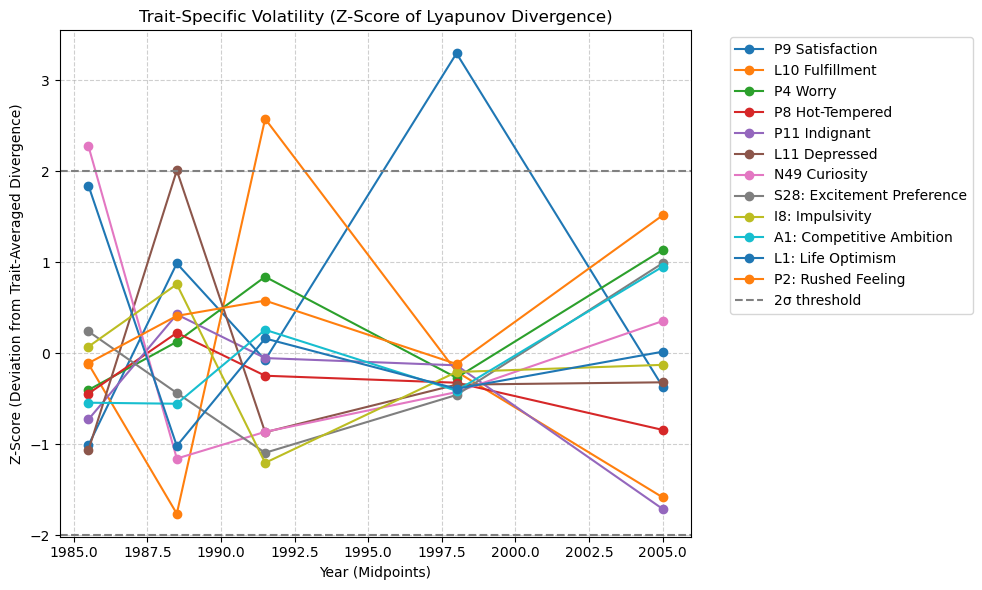


Trait Volatility Summary (Lyapunov Divergence):
P9 Satisfaction                 Mean=0.1556, Std=0.2300, Slope=+0.00976, R²=0.088
L10 Fulfillment                 Mean=0.0491, Std=0.0240, Slope=-0.00144, R²=0.177
P4 Worry                        Mean=0.0532, Std=0.0059, Slope=+0.00048, R²=0.330
P8 Hot-Tempered                 Mean=0.0417, Std=0.0106, Slope=-0.00098, R²=0.426
P11 Indignant                   Mean=0.0440, Std=0.0204, Slope=-0.00087, R²=0.090
L11 Depressed                   Mean=0.0410, Std=0.0164, Slope=-0.00033, R²=0.020
N49 Curiosity                   Mean=0.0553, Std=0.0468, Slope=-0.00298, R²=0.198
S28: Excitement Preference      Mean=0.0437, Std=0.0226, Slope=-0.00045, R²=0.020
I8: Impulsivity                 Mean=0.0495, Std=0.0205, Slope=-0.00071, R²=0.059
A1: Competitive Ambition        Mean=0.0437, Std=0.0098, Slope=+0.00037, R²=0.069
L1: Life Optimism               Mean=0.0560, Std=0.0385, Slope=-0.00282, R²=0.264
P2: Rushed Feeling              Mean=0.0611, Std=

In [81]:
# MODULE 3 B
#Associated with 'Figure 9' in in arXiv:2506.20622
#
# Z-Score Computation:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.stats import zscore, linregress

# === Define years and midpoints ===
years = [1984, 1987, 1990, 1993, 2003, 2007]
mid_years = [(years[i] + years[i+1]) / 2 for i in range(len(years) - 1)]

# === Trait frequency data (Likert 1–5 response distributions) ===
trait_data = {
    "P9 Satisfaction": [
        [76, 231, 294, 611, 698], #Row 1984: Likert scores 1 → 5
        [48, 146, 248, 523, 593], #Row 1987: Same structure throughout
        [40, 125, 288, 480, 489], #Row 1990
        [29, 158, 289, 447, 480], #Row 1993
        [92, 443, 156, 68, 15],   #Row 2003
        [85, 354, 138, 40, 17]    #Row 2007
    ],
    "L10 Fulfillment": [
        [193, 348, 445, 539, 382],
        [114, 252, 448, 447, 291],
        [106, 230, 423, 424, 240],
        [92, 212, 461, 344, 290],
        [40, 110, 239, 235, 149],
        [25, 95, 197, 189, 126]
    ],
    "P4 Worry": [
        [159, 374, 325, 548, 527],
        [95, 241, 300, 476, 448],
        [74, 229, 309, 455, 359],
        [85, 250, 316, 391, 364],
        [29, 133, 175, 250, 185],
        [22, 113, 171, 179, 144]
    ],
    "P8 Hot-Tempered": [
        [124, 249, 287, 473, 780],
        [73, 162, 280, 360, 683],
        [60, 156, 254, 376, 576],
        [43, 179, 243, 350, 586],
        [12, 75, 137, 214, 335],
        [17, 59, 119, 178, 259]
    ],
    "P11 Indignant": [
        [185, 457, 334, 524, 415],
        [114, 332, 312, 448, 345],
        [101, 337, 329, 381, 280],
        [112, 353, 305, 344, 289],
        [53, 163, 204, 217, 139],
        [38, 139, 166, 176, 109]
    ],
    "L11 Depressed": [
        [103, 159, 269, 527, 855],
        [54, 105, 251, 450, 700],
        [38, 98, 263, 464, 563],
        [40, 114, 265, 453, 535],
        [13, 52, 135, 253, 323],
        [9, 43, 127, 200, 246]
    ],
    "N49 Curiosity": [
        [229, 520, 295, 310, 218],
        [116, 371, 402, 346, 287],
        [97, 343, 401, 319, 237],
        [99, 327, 385, 334, 245],
        [44, 196, 207, 189, 125],
        [31, 164, 193, 136, 103]
    ],
    "S28: Excitement Preference": [
        [168, 408, 514, 468, 348],
        [107, 365, 502, 360, 211],
        [94, 343, 505, 309, 168],
        [91, 341, 505, 285, 174],
        [38, 180, 287, 166, 101],
        [28, 140, 266, 128, 67]
    ],
    "I8: Impulsivity": [
        [189, 332, 263, 584, 556],
        [108, 241, 313, 457, 450],
        [110, 228, 294, 452, 343],
        [113, 236, 284, 437, 351],
        [46, 117, 181, 266, 165],
        [27, 84, 154, 214, 154]
    ],
    "A1: Competitive Ambition": [
        [78, 190, 318, 501, 836],
        [38, 98, 279, 455, 700],
        [34, 97, 292, 402, 600],
        [36, 131, 302, 368, 570],
        [16, 72, 184, 207, 297],
        [11, 67, 171, 170, 213]
    ],
    "L1: Life Optimism": [
        [278, 656, 515, 322, 156],
        [154, 444, 589, 238, 137],
        [117, 393, 569, 231, 112],
        [97, 363, 578, 264, 104],
        [36, 219, 316, 138, 63],
        [31, 156, 270, 121, 53]
    ],
    "P2: Rushed Feeling": [
        [337, 573, 274, 429, 312],
        [207, 435, 293, 368, 269],
        [149, 369, 310, 365, 237],
        [133, 411, 299, 327, 238],
        [54, 183, 185, 190, 162],
        [44, 146, 135, 191, 116]
    ]
}

# === Lyapunov divergence computation ===
def compute_local_lyapunov(data):
    data = normalize(data, norm='l1')
    return [np.linalg.norm(data[i+1] - data[i]) for i in range(len(data)-1)]

trait_names = list(trait_data.keys())
lyapunov_values = []

for trait in trait_names:
    data = np.array(trait_data[trait])
    lyap = compute_local_lyapunov(data)
    lyapunov_values.append(lyap)

# === Convert to array and compute Z-scores ===
lyapunov_array = np.array(lyapunov_values)
z_scores = zscore(lyapunov_array, axis=0)

# === Plotting volatility (Z-score of Lyapunov divergence) ===
plt.figure(figsize=(10, 6))
for i, trait in enumerate(trait_names):
    plt.plot(mid_years, z_scores[i], marker='o', label=trait)

plt.axhline(y=2, color='gray', linestyle='--', label='2σ threshold')
plt.axhline(y=-2, color='gray', linestyle='--')
plt.title("Trait-Specific Volatility (Z-Score of Lyapunov Divergence)")
plt.xlabel("Year (Midpoints)")
plt.ylabel("Z-Score (Deviation from Trait-Averaged Divergence)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Numerical summary: mean, std, linear trend of divergence ===
print("\nTrait Volatility Summary (Lyapunov Divergence):")
for i, trait in enumerate(trait_names):
    lyap = lyapunov_array[i]
    slope, intercept, r_value, p_value, std_err = linregress(mid_years, lyap)
    print(f"{trait:30s}  Mean={np.mean(lyap):.4f}, Std={np.std(lyap):.4f}, "
          f"Slope={slope:+.5f}, R²={r_value**2:.3f}")



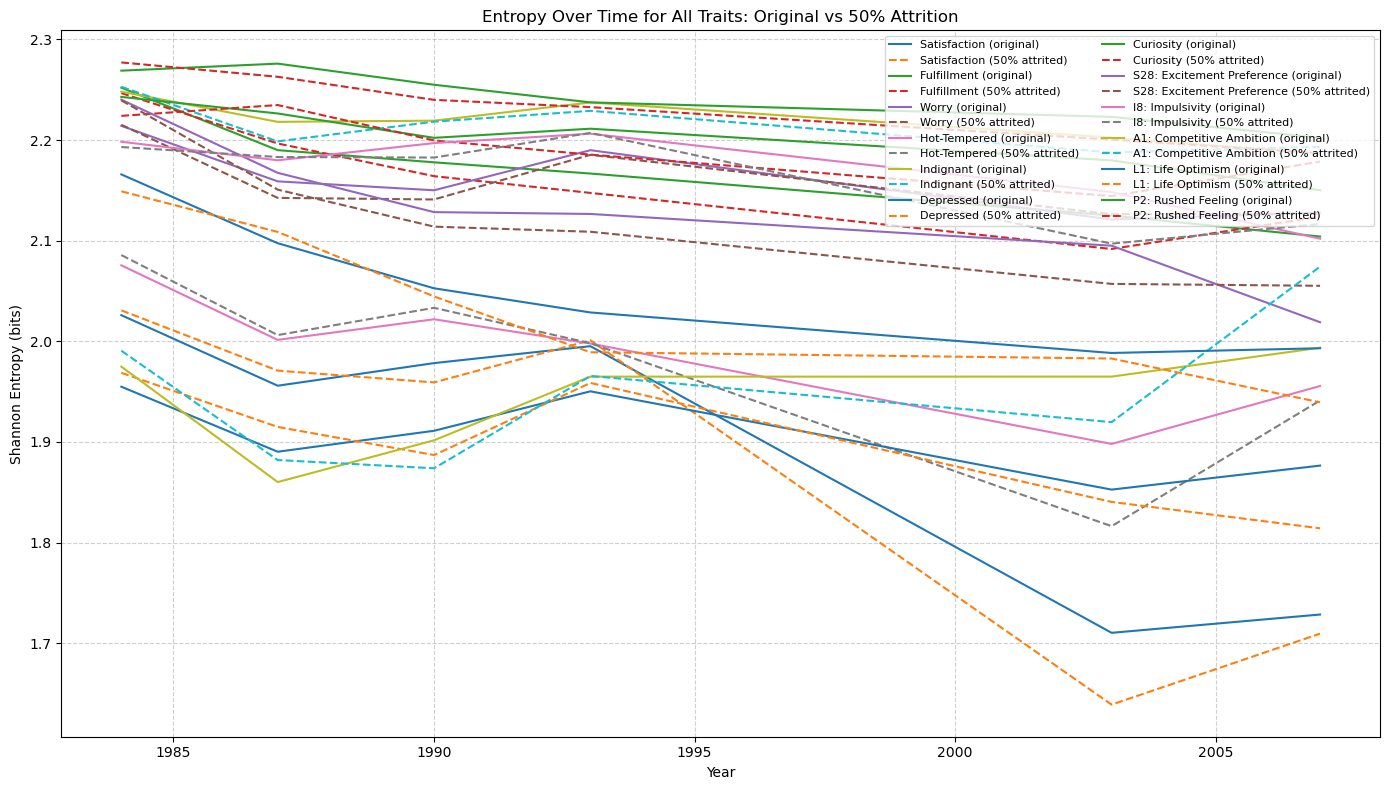

In [83]:
#Associated with 'Table 3' in Appendix B, in arXiv:2506.20622
#
# APPENDIX B: Entropy Stability Under Simulated Attrition
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import random

# === Full trait dataset ===
trait_data = {
    "Satisfaction": [
        [76, 231, 294, 611, 698],
        [48, 146, 248, 523, 593],
        [40, 125, 288, 480, 489],
        [29, 158, 289, 447, 480],
        [92, 443, 156, 68, 15],
        [85, 354, 138, 40, 17]
    ],
    "Fulfillment": [
        [193, 348, 445, 539, 382],
        [114, 252, 448, 447, 291],
        [106, 230, 423, 424, 240],
        [92, 212, 461, 344, 290],
        [40, 110, 239, 235, 149],
        [25, 95, 197, 189, 126]
    ],
    "Worry": [
        [159, 374, 325, 548, 527],
        [95, 241, 300, 476, 448],
        [74, 229, 309, 455, 359],
        [85, 250, 316, 391, 364],
        [29, 133, 175, 250, 185],
        [22, 113, 171, 179, 144]
    ],
    "Hot-Tempered": [
        [124, 249, 287, 473, 780],
        [73, 162, 280, 360, 683],
        [60, 156, 254, 376, 576],
        [43, 179, 243, 350, 586],
        [12, 75, 137, 214, 335],
        [17, 59, 119, 178, 259]
    ],
    "Indignant": [
        [185, 457, 334, 524, 415],
        [114, 332, 312, 448, 345],
        [101, 337, 329, 381, 280],
        [112, 353, 305, 344, 289],
        [53, 163, 204, 217, 139],
        [38, 139, 166, 176, 109]
    ],
    "Depressed": [
        [103, 159, 269, 527, 855],
        [54, 105, 251, 450, 700],
        [38, 98, 263, 464, 563],
        [40, 114, 265, 453, 535],
        [13, 52, 135, 253, 323],
        [9, 43, 127, 200, 246]
    ],
    "Curiosity": [
        [229, 520, 295, 310, 218],
        [116, 371, 402, 346, 287],
        [97, 343, 401, 319, 237],
        [99, 327, 385, 334, 245],
        [44, 196, 207, 189, 125],
        [31, 164, 193, 136, 103]
    ],
    "S28: Excitement Preference": [
        [168, 408, 514, 468, 348],
        [107, 365, 502, 360, 211],
        [94, 343, 505, 309, 168],
        [91, 341, 505, 285, 174],
        [38, 180, 287, 166, 101],
        [28, 140, 266, 128, 67]
    ],
    "I8: Impulsivity": [
        [189, 332, 263, 584, 556],
        [108, 241, 313, 457, 450],
        [110, 228, 294, 452, 343],
        [113, 236, 284, 437, 351],
        [46, 117, 181, 266, 165],
        [27, 84, 154, 214, 154],
    ],
    "A1: Competitive Ambition": [
        [78, 190, 318, 501, 836],
        [38, 98, 279, 455, 700],
        [34, 97, 292, 402, 600],
        [36, 131, 302, 368, 570],
        [16, 72, 184, 207, 297],
        [11, 67, 171, 170, 213],
    ],
    "L1: Life Optimism": [
        [278, 656, 515, 322, 156],
        [154, 444, 589, 238, 137],
        [117, 393, 569, 231, 112],
        [97, 363, 578, 264, 104],
        [36, 219, 316, 138, 63],
        [31, 156, 270, 121, 53],
    ],
    "P2: Rushed Feeling": [
        [337, 573, 274, 429, 312],
        [207, 435, 293, 368, 269],
        [149, 369, 310, 365, 237],
        [133, 411, 299, 327, 238],
        [54, 183, 185, 190, 162],
        [44, 146, 135, 191, 116]
    ]
}

years = [1984, 1987, 1990, 1993, 2003, 2007]

# Compute Shannon entropy
def compute_entropy(dist):
    total = sum(dist)
    if total == 0:
        return 0
    probs = [x / total for x in dist if x > 0]
    return -sum(p * np.log2(p) for p in probs)

# Apply dropout
def apply_attrition(dist, dropout_rate=0.5):
    np.random.seed(42)
    return [[np.random.binomial(count, 1 - dropout_rate) for count in wave] for wave in dist]

# Compute entropy curves
entropy_curves_original = {}
entropy_curves_attrited = {}

for trait, dist in trait_data.items():
    entropy_original = [compute_entropy(wave) for wave in dist]
    entropy_attrited = [compute_entropy(wave) for wave in apply_attrition(dist)]
    entropy_curves_original[trait] = entropy_original
    entropy_curves_attrited[trait] = entropy_attrited

# Plot
plt.figure(figsize=(14, 8))
for trait in trait_data:
    plt.plot(years, entropy_curves_original[trait], linestyle='-', label=f"{trait} (original)")
    plt.plot(years, entropy_curves_attrited[trait], linestyle='--', label=f"{trait} (50% attrited)")

plt.title("Entropy Over Time for All Traits: Original vs 50% Attrition")
plt.xlabel("Year")
plt.ylabel("Shannon Entropy (bits)")
plt.legend(fontsize=8, loc='upper right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



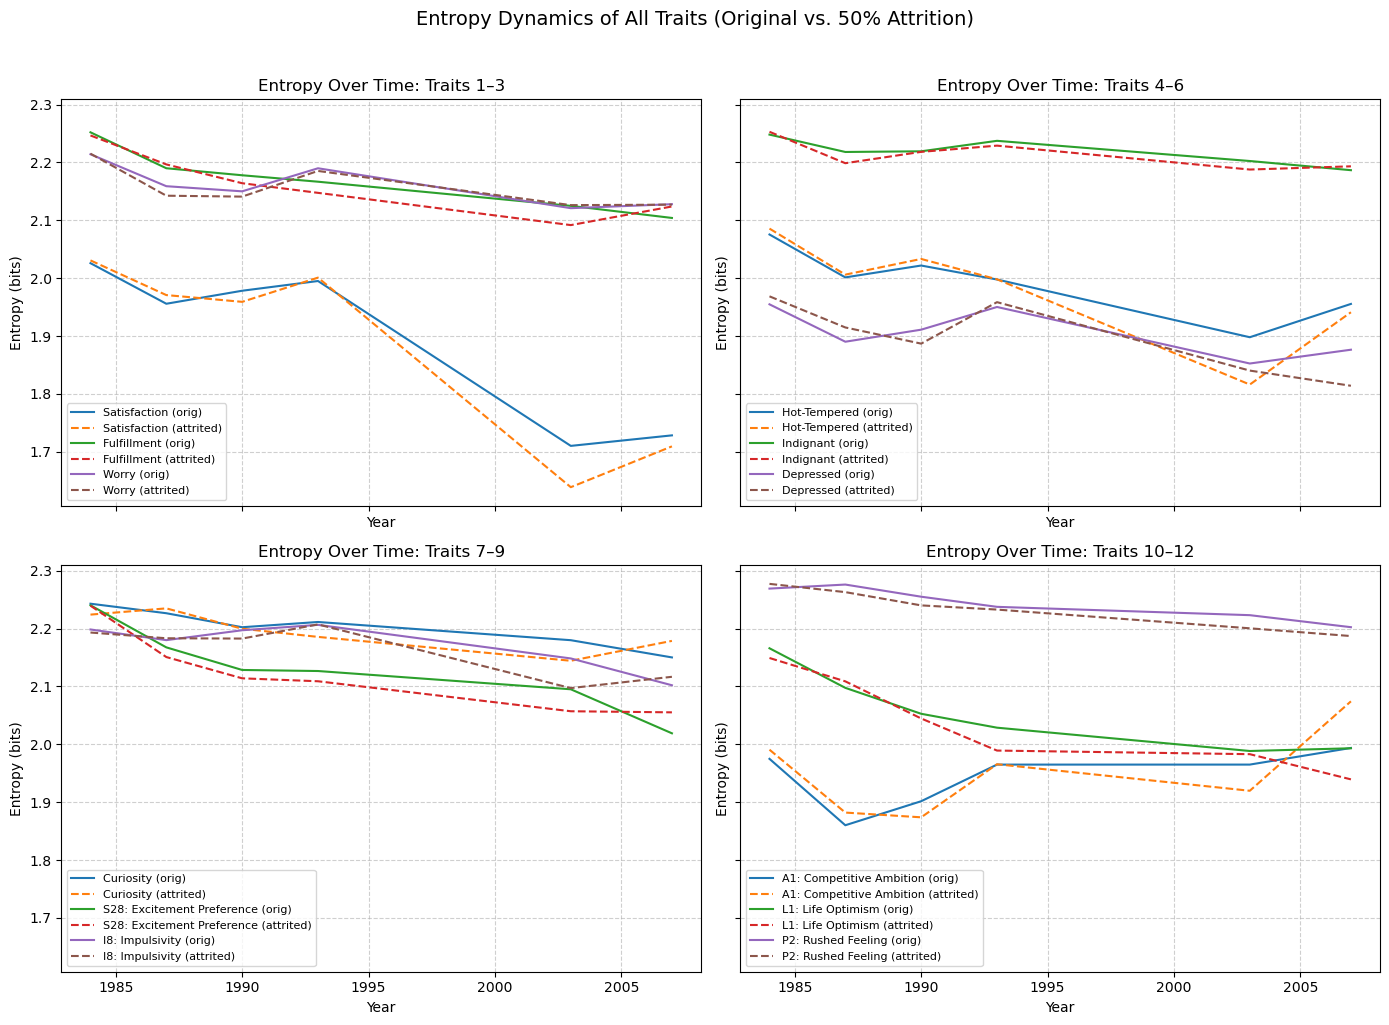

In [85]:
#Associated with 'Figure 10' in in arXiv:2506.20622
#
# APPENDIX B: Entropy Stability Under Simulated Attrition
#
import numpy as np
import matplotlib.pyplot as plt

# === Assume trait_data, years, and compute_entropy/apply_attrition are defined as above ===

# === Compute entropy for original and attrited data ===
entropy_curves_original = {}
entropy_curves_attrited = {}

for trait, dist in trait_data.items():
    entropy_original = [compute_entropy(wave) for wave in dist]
    entropy_attrited = [compute_entropy(wave) for wave in apply_attrition(dist)]
    entropy_curves_original[trait] = entropy_original
    entropy_curves_attrited[trait] = entropy_attrited

# === Setup subplots ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

# === Organize traits into 4 groups of 3 ===
trait_groups = [
    ["Satisfaction", "Fulfillment", "Worry"],
    ["Hot-Tempered", "Indignant", "Depressed"],
    ["Curiosity", "S28: Excitement Preference", "I8: Impulsivity"],
    ["A1: Competitive Ambition", "L1: Life Optimism", "P2: Rushed Feeling"]
]

# === Plot each group ===
for i, group in enumerate(trait_groups):
    ax = axes[i]
    for trait in group:
        ax.plot(years, entropy_curves_original[trait], label=f"{trait} (orig)", linestyle='-')
        ax.plot(years, entropy_curves_attrited[trait], label=f"{trait} (attrited)", linestyle='--')
    ax.set_title(f"Entropy Over Time: Traits {3*i+1}–{3*i+3}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Entropy (bits)")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=8)

plt.suptitle("Entropy Dynamics of All Traits (Original vs. 50% Attrition)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [87]:
#Associated with 'Table 3' in Appendix B, in arXiv:2506.20622
#
# APPENDIX B: Entropy Stability Under Simulated Attrition
#
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# === Compare entropy curves for all traits ===
rmse_list = []
mae_list = []
max_diff_list = []
final_change_list = []

for trait in trait_data:
    original = entropy_curves_original[trait]
    attrited = entropy_curves_attrited[trait]
    
    rmse = np.sqrt(mean_squared_error(original, attrited))
    mae = mean_absolute_error(original, attrited)
    max_diff = np.max(np.abs(np.array(original) - np.array(attrited)))
    final_change = 100 * (attrited[-1] - original[-1]) / original[-1] if original[-1] != 0 else np.nan

    rmse_list.append(rmse)
    mae_list.append(mae)
    max_diff_list.append(max_diff)
    final_change_list.append(final_change)

# === Create and display results table ===
results_df = pd.DataFrame({
    "Trait": list(trait_data.keys()),
    "RMSE": rmse_list,
    "MAE": mae_list,
    "Max Absolute Diff": max_diff_list,
    "% Change in Final Entropy": final_change_list
})

results_df = results_df.sort_values(by="RMSE", ascending=False)
results_df.reset_index(drop=True, inplace=True)

# Display the results
print(results_df.to_string(index=False))


                     Trait     RMSE      MAE  Max Absolute Diff  % Change in Final Entropy
  A1: Competitive Ambition 0.040922 0.032001           0.080609                   4.043342
              Hot-Tempered 0.034513 0.020464           0.081757                  -0.734684
              Satisfaction 0.031898 0.022532           0.071369                  -1.100098
                 Depressed 0.030224 0.024239           0.062311                  -3.320695
         L1: Life Optimism 0.028743 0.022490           0.053743                  -2.696467
S28: Excitement Preference 0.024341 0.020622           0.037962                   1.794060
                 Curiosity 0.023003 0.019952           0.035537                   1.327861
           I8: Impulsivity 0.022678 0.014918           0.051253                   0.695856
               Fulfillment 0.018851 0.016357           0.033252                   0.941624
        P2: Rushed Feeling 0.014352 0.013170           0.022713                  -0.695322

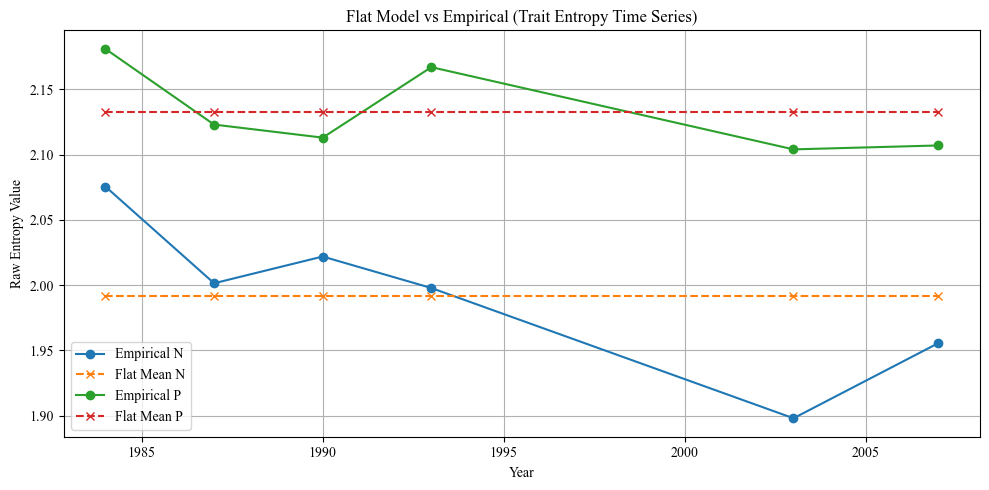

{'Flat Mean Results': {'P8 Hot-Tempered (N)': {'RMSE': 0.055011614547647074,
   'R^2': 0.0},
  'P4 Worry (P)': {'RMSE': 0.03020899424564361, 'R^2': 0.0}}}

In [89]:
# Associated with 'Figure 11' in Appendix C.1, in arXiv:2506.20622
#
# APPENDIX C.1: Model Evaluation: Null vs. ECTO Dynamical Systems
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
# Empirical data 
N_empirical = np.array([2.075515, 2.001416, 2.021902, 1.997771, 1.897984, 1.955553])
P_empirical = np.array([2.181, 2.123, 2.113, 2.167, 2.104, 2.107])
years = np.array([1984, 1987, 1990, 1993, 2003, 2007])

# Compute Mean AFTER Normalization 
mean_N = np.mean(N_empirical)
mean_P = np.mean(P_empirical)

# Flat Mean Baseline Model 
N_flat = np.full_like(N_empirical, mean_N)
P_flat = np.full_like(P_empirical, mean_P)

# RMSE and R^2 
rmse_N_flat = np.sqrt(mean_squared_error(N_empirical, N_flat))
rmse_P_flat = np.sqrt(mean_squared_error(P_empirical, P_flat))
r2_N_flat = r2_score(N_empirical, N_flat)
r2_P_flat = r2_score(P_empirical, P_flat)

# Plot Comparison
plt.figure(figsize=(10, 5))
plt.plot(years, N_empirical, 'o-', label='Empirical N')
plt.plot(years, N_flat, 'x--', label='Flat Mean N')
plt.plot(years, P_empirical, 'o-', label='Empirical P')
plt.plot(years, P_flat, 'x--', label='Flat Mean P')
plt.xlabel("Year")
plt.ylabel("Raw Entropy Value")
plt.title("Flat Model vs Empirical (Trait Entropy Time Series)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Return numeric validation
{
    "Flat Mean Results": {
        "P8 Hot-Tempered (N)": {
            "RMSE": rmse_N_flat,
            "R^2": r2_N_flat
        },
        "P4 Worry (P)": {
            "RMSE": rmse_P_flat,
            "R^2": r2_P_flat
        }
    }
}


Running global optimization with alpha tuning...

 Optimized Parameters (via differential_evolution with alpha):
mu = 0.01000, alpha = 0.01000, beta = 0.01000, gamma = 0.01027
c1 = 0.10000, c2 = 0.52310, c3 = 0.01019, K = 1.84118

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.1343
RMSE for P4 Worry: 0.0221
R² for P8 Hot-Tempered: -4.9623
R² for P4 Worry: 0.5496
Pearson r (N): 0.871 (p=0.024)
Pearson r (P): 0.800 (p=0.056)
DTW distance (N): 0.486
DTW distance (P): 0.095


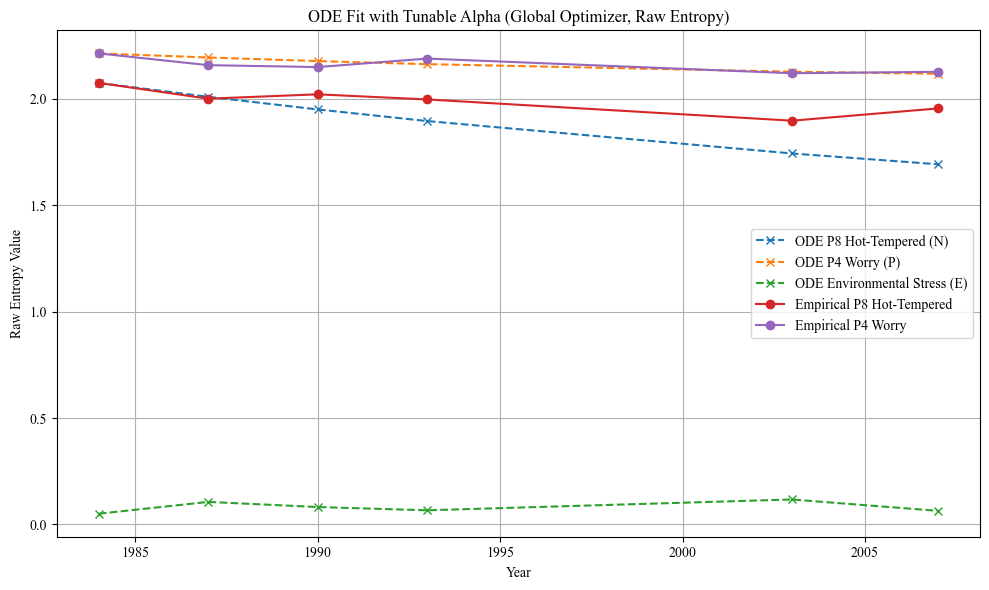

In [91]:
# Associated with 'Figure 12' in Appendix C.1, in arXiv:2506.20622
#
# APPENDIX C.1: Model Evaluation: Null vs. ECTO Dynamical Systems
#
# ECTO ODE System — Global Optimizer with Tunable Alpha (Raw Entropy)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

#  Raw Entropy Data 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28: Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8: Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1: Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1: Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2: Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

# Trait Pair Selection 
trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]
N_empirical = df[trait_x].values
P_empirical = df[trait_y].values
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# ODE System (now with alpha) 
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# Objective Function with Penalty 
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    try:
        sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
        N, P, E = sol.T
        if np.any(np.isnan(N)) or np.any(np.abs(N) > 10) or np.any(np.abs(P) > 10):
            return 1e6
        error_N = np.sum((N - N_empirical)**2)
        error_P = np.sum((P - P_empirical)**2)
        return error_N + error_P
    except:
        return 1e6

# Wide Bounds (including alpha) 
bounds = [
    (1e-6, 0.01),   # mu
    (0.01, 1.0),    # alpha (formerly fixed at 0.15)
    (0.01, 0.5),    # beta
    (0.01, 0.5),    # gamma
    (0.1, 2.0),     # c1
    (0.1, 2.0),     # c2
    (0.01, 2.0),    # c3
    (0.2, 2.0)      # K
]

# Run Global Optimization 
print("Running global optimization with alpha tuning...")
result = differential_evolution(objective, bounds, maxiter=2000, tol=1e-6, seed=42)
mu, alpha, beta, gamma, c1, c2, c3, K = result.x

# Final Simulation with Optimal Parameters 
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation Metrics 
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)
rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)

# DTW Function 
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# Output
print(f"\n Optimized Parameters (via differential_evolution with alpha):")
print(f"mu = {mu:.5f}, alpha = {alpha:.5f}, beta = {beta:.5f}, gamma = {gamma:.5f}")
print(f"c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")


# Plot
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title("ODE Fit with Tunable Alpha (Global Optimizer, Raw Entropy)")
plt.xlabel("Year")
plt.ylabel("Raw Entropy Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



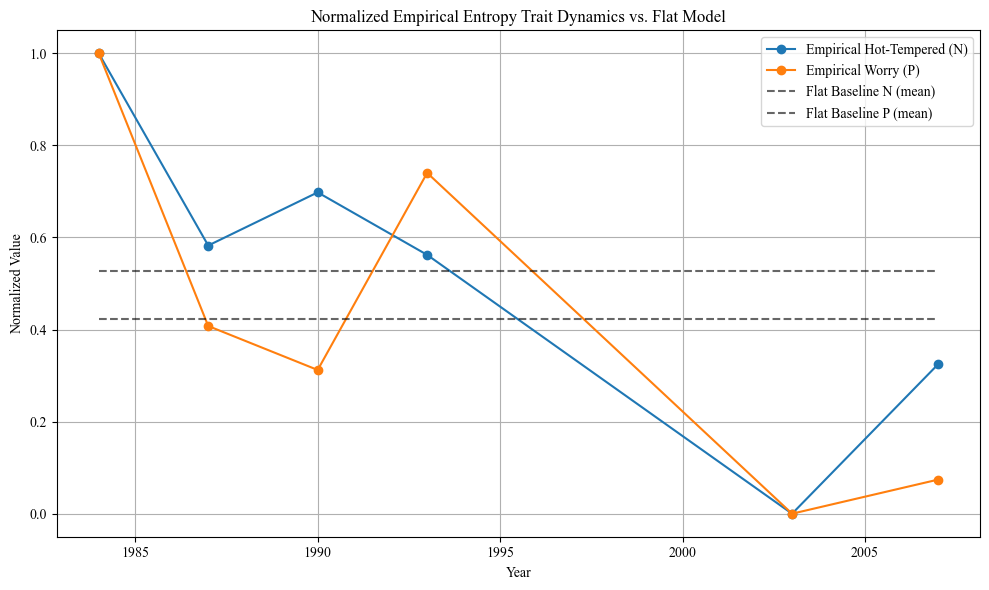

Flat Model Validation Metrics:
P8 Hot-Tempered (N): RMSE = 0.3098, R² = 0.0000
P4 Worry (P):        RMSE = 0.3528, R² = 0.0000


In [94]:
# Associated with 'Figure 13' in Appendix C.1, in arXiv:2506.20622
#
# APPENDIX C.1: Model Evaluation: Null vs. ECTO Dynamical Systems
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

# Load entropy data
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023],
}
df = pd.DataFrame(data)

# Normalize data
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

years = df["Year"].values
t_data = years - years[0]
N_empirical = normalize(df["P8 Hot-Tempered"].values)
P_empirical = normalize(df["P4 Worry"].values)

# Mean and variance lines for overlay
mean_N = np.mean(N_empirical)
mean_P = np.mean(P_empirical)
var_N = np.var(N_empirical)
var_P = np.var(P_empirical)

# Simulate a basic "flat model" baseline for comparison
N_flat = np.full_like(N_empirical, mean_N)
P_flat = np.full_like(P_empirical, mean_P)

# Plotting overlay with "flat model" baseline
plt.figure(figsize=(10, 6))
plt.plot(years, N_empirical, 'o-', label='Empirical Hot-Tempered (N)')
plt.plot(years, P_empirical, 'o-', label='Empirical Worry (P)')
plt.plot(years, N_flat, 'k--', label='Flat Baseline N (mean)', alpha=0.6)
plt.plot(years, P_flat, 'k--', label='Flat Baseline P (mean)', alpha=0.6)
plt.title("Normalized Empirical Entropy Trait Dynamics vs. Flat Model")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === RMSE and R² for Flat Model ===
rmse_N_flat = np.sqrt(mean_squared_error(N_empirical, N_flat))
rmse_P_flat = np.sqrt(mean_squared_error(P_empirical, P_flat))
r2_N_flat = r2_score(N_empirical, N_flat)
r2_P_flat = r2_score(P_empirical, P_flat)

# === Print Results ===
print("Flat Model Validation Metrics:")
print(f"P8 Hot-Tempered (N): RMSE = {rmse_N_flat:.4f}, R² = {r2_N_flat:.4f}")
print(f"P4 Worry (P):        RMSE = {rmse_P_flat:.4f}, R² = {r2_P_flat:.4f}")



Manual Parameters:
mu = 0.00001, alpha =  0.15000, beta = 0.16746, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 5.60000, K = 0.50000

Validation Metrics:
RMSE for P8 Hot-Tempered: 0.1552
RMSE for P4 Worry: 0.2516
R² for P8 Hot-Tempered: 0.7490
R² for P4 Worry: 0.4914
Pearson r (N): 0.869 (p=0.025)
Pearson r (P): 0.798 (p=0.057)

DTW distance (N): 0.696
DTW distance (P): 0.797


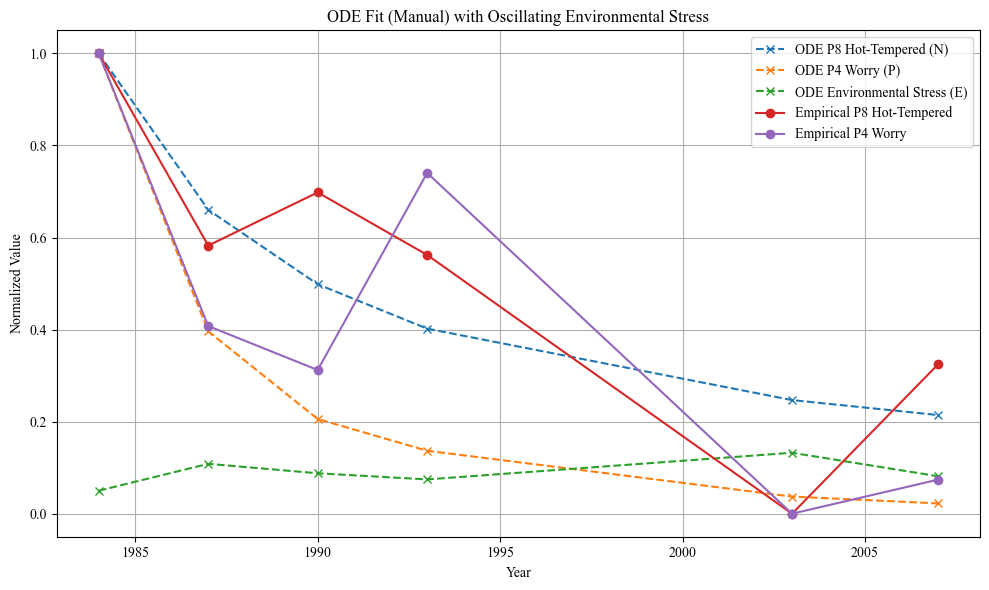

In [118]:
# Associated with 'Figure 14' in Appendix C.1, in arXiv:2506.20622
#
# APPENDIX C.1: Model Evaluation: Null vs. ECTO Dynamical Systems
#
# ECTO Nonlinear ODE System
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023]
}
df = pd.DataFrame(data)

trait_x = "P8 Hot-Tempered"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System with Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, alpha, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.1, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.001, 1.0), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, alpha, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    alpha = .15
    beta  = 0.16746
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 05.60   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# Output 
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, alpha = {alpha: .5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Oscillating Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



R² min (N): -0.876
R² max (N): 0.764 at α = 0.128, β = 0.120
R² mean (N): 0.495 ± 0.391
276/400 combinations had R² (N) > 0.5 (69.0%)
R² min (P): 0.316
R² max (P): 0.596 at α = 0.150, β = 0.120
R² mean (P): 0.451 ± 0.080
127/400 combinations had R² (P) > 0.5 (31.8%)


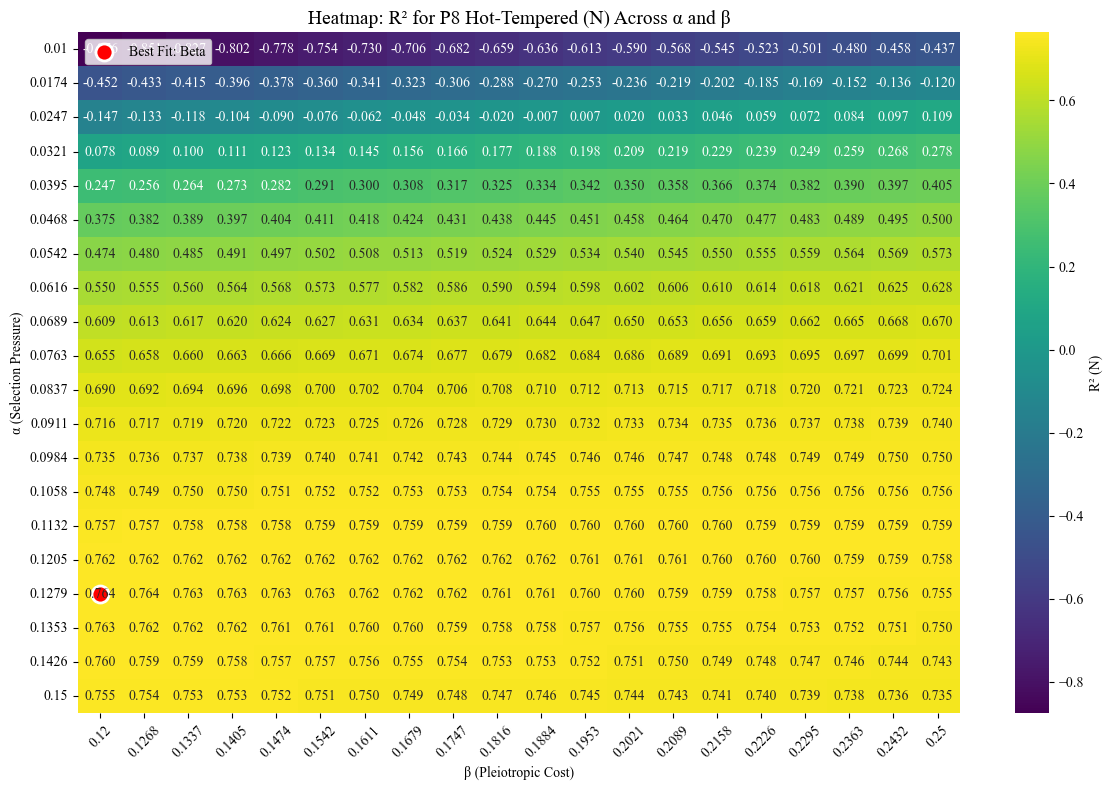

In [120]:
# Associated with 'Figure 15' in Appendix C.2, in arXiv:2506.20622
#
# APPENDIX C.2: Parameter Sensitivity
# Note: This is the 'general' script associated with section C.2
# For full reproducibility of results see: 'Trait by Trait' 
# module associated with this GitHub repository
#
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

# Sweep alpha and beta
alpha_values = np.linspace(0.01, 0.15, 20)  # α = selection cost
beta_values = np.linspace(0.12, 0.25, 20)   # β = pleiotropic penalty

r2_results_N = np.zeros((len(alpha_values), len(beta_values)))
r2_results_P = np.zeros((len(alpha_values), len(beta_values)))
rmse_results_N = np.zeros_like(r2_results_N)
rmse_results_P = np.zeros_like(r2_results_P)

# Fixed parameters
mu = 0.00001
gamma = 0.03
c1 = 2.0
c2 = 0.21
c3 = 5.60  # ← Environmental stress term: unperturbed
K = 0.5

# Updated ODE to use alpha dynamically
def system_sweep(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# Perform sweep
for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        sol = odeint(system_sweep, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
        N_model, P_model, _ = sol.T

        r2_results_N[i, j] = r2_score(N_empirical, N_model)
        r2_results_P[i, j] = r2_score(P_empirical, P_model)
        rmse_results_N[i, j] = np.sqrt(mean_squared_error(N_empirical, N_model))
        rmse_results_P[i, j] = np.sqrt(mean_squared_error(P_empirical, P_model))

alpha_labels = [round(a, 4) for a in alpha_values]
beta_labels = [round(b, 4) for b in beta_values]

r2_df_N = pd.DataFrame(r2_results_N, index=alpha_labels, columns=beta_labels)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(r2_df_N, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'R² (N)'})
plt.title("Heatmap: R² for P8 Hot-Tempered (N) Across α and β", fontsize=14)
plt.xlabel("β (Pleiotropic Cost)")
plt.ylabel("α (Selection Pressure)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Optional: Highlight best value
max_idx = np.unravel_index(np.argmax(r2_results_N), r2_results_N.shape)
best_alpha = alpha_labels[max_idx[0]]
best_beta = beta_labels[max_idx[1]]
plt.scatter(x=max_idx[1]+0.5, y=max_idx[0]+0.5, s=150, c="red", edgecolors="white", linewidth=2, label="Best Fit: Beta")
plt.legend(loc="upper left")

# Flatten for analysis N trait
r2_flat = r2_results_N.flatten()

# Basic statistics
r2_min = np.min(r2_flat)
r2_max = np.max(r2_flat)
r2_mean = np.mean(r2_flat)
r2_std = np.std(r2_flat)

# Best parameter combo
best_idx = np.unravel_index(np.argmax(r2_results_N), r2_results_N.shape)
best_alpha = alpha_values[best_idx[0]]
best_beta = beta_values[best_idx[1]]
best_r2 = r2_results_N[best_idx]

# Count how many parameter sets exceed a threshold (e.g., R² > 0.5)
threshold = 0.5
num_above_thresh = np.sum(r2_results_N > threshold)
total_tests = r2_results_N.size
percent_above = 100 * num_above_thresh / total_tests

# Report
print(f"R² min (N): {r2_min:.3f}")
print(f"R² max (N): {r2_max:.3f} at α = {best_alpha:.3f}, β = {best_beta:.3f}")
print(f"R² mean (N): {r2_mean:.3f} ± {r2_std:.3f}")
print(f"{num_above_thresh}/{total_tests} combinations had R² (N) > {threshold} ({percent_above:.1f}%)")

# Flatten for P (Worry)
r2_flat_P = r2_results_P.flatten()

# Basic stats for P
r2_min_P = np.min(r2_flat_P)
r2_max_P = np.max(r2_flat_P)
r2_mean_P = np.mean(r2_flat_P)
r2_std_P = np.std(r2_flat_P)

# Best (α, β) for P
best_idx_P = np.unravel_index(np.argmax(r2_results_P), r2_results_P.shape)
best_alpha_P = alpha_values[best_idx_P[0]]
best_beta_P = beta_values[best_idx_P[1]]
best_r2_P = r2_results_P[best_idx_P]

# Threshold count
threshold = 0.5
num_above_P = np.sum(r2_results_P > threshold)
total_tests = r2_results_P.size
percent_above_P = 100 * num_above_P / total_tests

# Print
print(f"R² min (P): {r2_min_P:.3f}")
print(f"R² max (P): {r2_max_P:.3f} at α = {best_alpha_P:.3f}, β = {best_beta_P:.3f}")
print(f"R² mean (P): {r2_mean_P:.3f} ± {r2_std_P:.3f}")
print(f"{num_above_P}/{total_tests} combinations had R² (P) > {threshold} ({percent_above_P:.1f}%)")


plt.tight_layout()
plt.show()


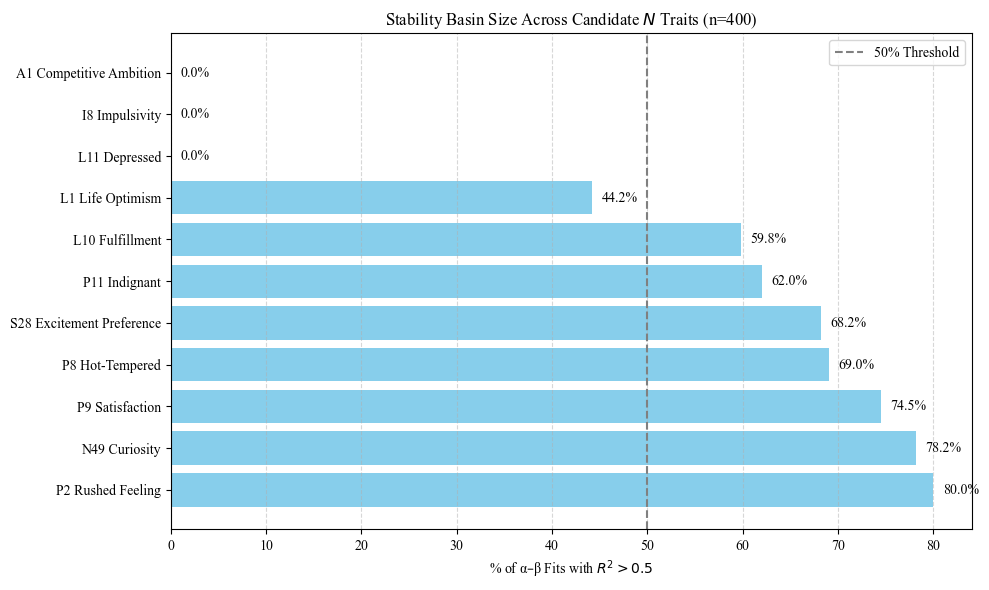

In [121]:
# Associated with 'Figure 17' in Appendix C.3, in arXiv:2506.20622
#
# APPENDIX C.3: Parameter Sensitivity
# Note: For full reproducibility of C.3 results see: 
#'Trait by Trait' module associated with this GitHub repository
import matplotlib.pyplot as plt

# Correct trait names and corresponding % of α–β combinations with R²(N) > 0.5
traits = [
    "A1 Competitive Ambition", "I8 Impulsivity", "L11 Depressed",
    "L1 Life Optimism", "L10 Fulfillment", "P11 Indignant",
    "S28 Excitement Preference", "P8 Hot-Tempered", "P9 Satisfaction",
    "N49 Curiosity", "P2 Rushed Feeling"
]

percent_over_0_5 = [0.0, 0.0, 0.0, 44.2, 59.8, 62.0, 68.2, 69.0, 74.5, 78.2, 80.0]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(traits[::-1], percent_over_0_5[::-1], color='skyblue')

# Add threshold line and axis labels
plt.axvline(x=50, color='gray', linestyle='--', label='50% Threshold')
plt.xlabel('% of α–β Fits with $R^2 > 0.5$')
plt.title('Stability Basin Size Across Candidate $N$ Traits (n=400)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend()

# Annotate each bar with percentage value
for i, value in enumerate(percent_over_0_5[::-1]):
    plt.text(value + 1, i, f"{value:.1f}%", va='center')

plt.tight_layout()
plt.show()


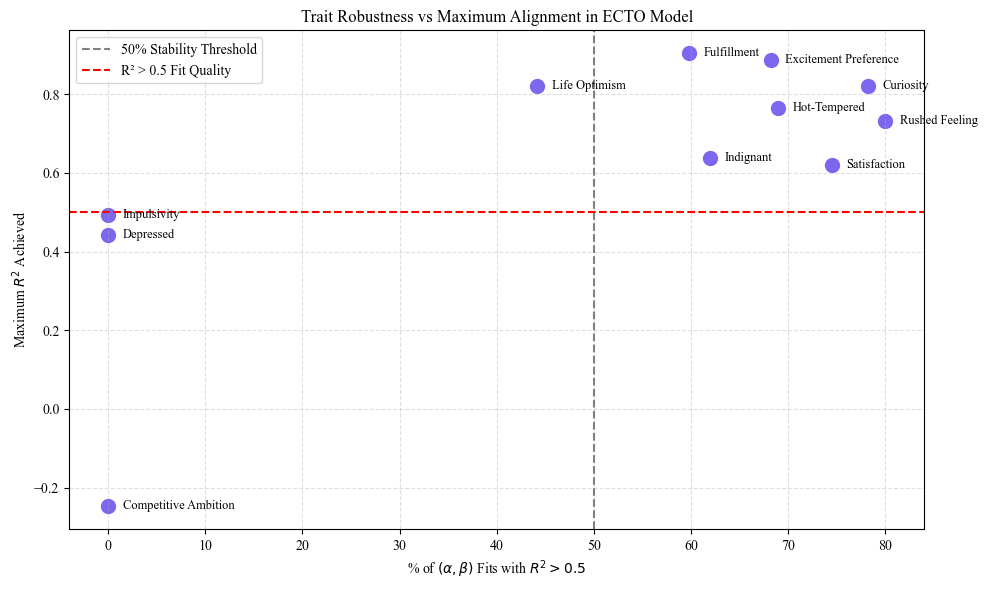

In [122]:
# Associated with 'Figure 18' in Appendix C.3, in arXiv:2506.20622
#
# APPENDIX C.3: Parameter Sensitivity
# Note: For full reproducibility of C.3 results see: 
#'Trait by Trait' module associated with this GitHub repository
import matplotlib.pyplot as plt

# Trait labels
traits = [
    "Hot-Tempered", "Fulfillment", "Satisfaction", "Indignant", "Rushed Feeling",
    "Excitement Preference", "Life Optimism", "Impulsivity", "Curiosity",
    "Depressed", "Competitive Ambition"
]

# Updated % of (α, β) combinations with R² > 0.5
percent_over_0_5 = [
    69.0, 59.8, 74.5, 62.0, 80.0,
    68.2, 44.2, 0.0, 78.2,
    0.0, 0.0
]

# Updated maximum R² achieved across sweep
max_r2 = [
    0.764, 0.905, 0.621, 0.637, 0.731,
    0.888, 0.820, 0.492, 0.822,
    0.442, -0.248
]

# Plot setup
plt.figure(figsize=(10, 6))
plt.scatter(percent_over_0_5, max_r2, s=100, color='mediumslateblue')

# Add labels to each point
for i, trait in enumerate(traits):
    plt.text(percent_over_0_5[i] + 1.5, max_r2[i], trait, fontsize=9, va='center')

# Reference lines
plt.axvline(x=50, color='gray', linestyle='--', label='50% Stability Threshold')
plt.axhline(y=0.5, color='red', linestyle='--', label='R² > 0.5 Fit Quality')

# Axis labels and title
plt.xlabel('% of $(\\alpha, \\beta)$ Fits with $R^2 > 0.5$')
plt.ylabel('Maximum $R^2$ Achieved')
plt.title('Trait Robustness vs Maximum Alignment in ECTO Model')

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


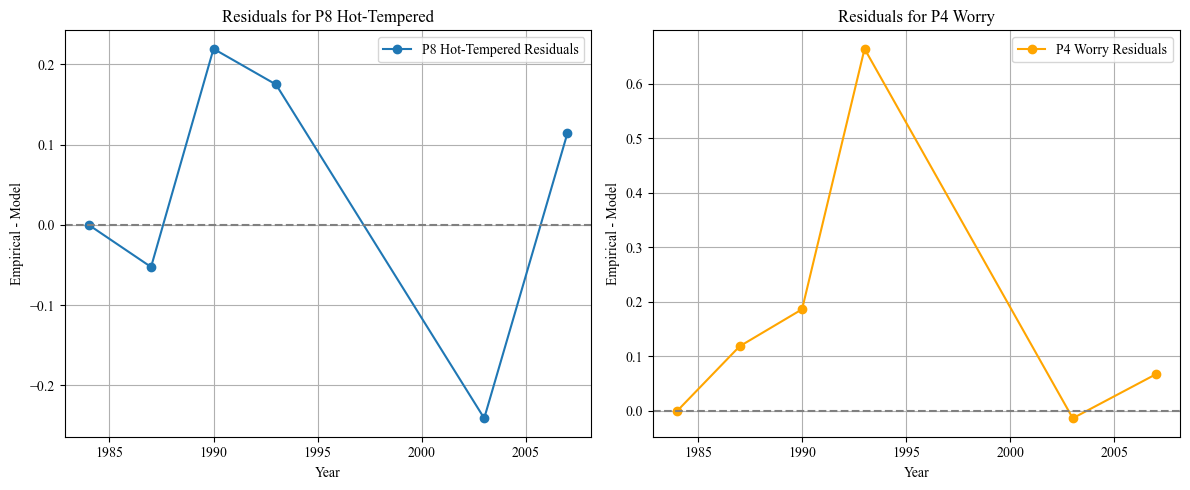


Residual Summary for P8 Hot-Tempered:
  Mean: 0.0358
  Std Dev: 0.1554
  Max: 0.2193
  Min: -0.2410
  Skewness: -0.5600
  Kurtosis: -0.8618
  Shapiro-Wilk Normality Test p-value: 0.6939 (normal)

Residual Summary for P4 Worry:
  Mean: 0.1706
  Std Dev: 0.2310
  Max: 0.6643
  Min: -0.0134
  Skewness: 1.4584
  Kurtosis: 0.5986
  Shapiro-Wilk Normality Test p-value: 0.0236 (non-normal)


In [126]:
# Associated with 'Table 5' in Appendix C.4, in arXiv:2506.20622
#
# APPENDIX C.4: Residual Analysis Across Trait Fits
# Note: For full reproducibility of C.4 results see: 
#'Trait by Trait' module associated with this GitHub repository
from scipy.stats import shapiro, skew, kurtosis

# Calculate Residuals
residuals_N = N_empirical - N_model
residuals_P = P_empirical - P_model

# Plot Residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(years, residuals_N, 'o-', label=f'{trait_x} Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Residuals for {trait_x}')
plt.xlabel("Year")
plt.ylabel("Empirical - Model")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(years, residuals_P, 'o-', color='orange', label=f'{trait_y} Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Residuals for {trait_y}')
plt.xlabel("Year")
plt.ylabel("Empirical - Model")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Residuals
residuals_N = N_empirical - N_model
residuals_P = P_empirical - P_model

# Summary Statistics
def summarize_residuals(residuals, label):
    print(f"\nResidual Summary for {label}:")
    print(f"  Mean: {np.mean(residuals):.4f}")
    print(f"  Std Dev: {np.std(residuals):.4f}")
    print(f"  Max: {np.max(residuals):.4f}")
    print(f"  Min: {np.min(residuals):.4f}")
    print(f"  Skewness: {skew(residuals):.4f}")
    print(f"  Kurtosis: {kurtosis(residuals):.4f}")
    _, p_val = shapiro(residuals)
    print(f"  Shapiro-Wilk Normality Test p-value: {p_val:.4f} {'(non-normal)' if p_val < 0.05 else '(normal)'}")

# Run Summary
summarize_residuals(residuals_N, trait_x)
summarize_residuals(residuals_P, trait_y)



Parameters: mu=1e-05, alpha =0.15 , beta=0.16746, gamma=0.03, c1=2.0, c2=0.21, c3=5.6, K=0.5, G=1.0
RMSE: P2 Rushed Feeling=0.2088, P4 Worry=0.2509
R²: P2 Rushed Feeling=0.6438, P4 Worry=0.4941
Pearson r: P2 Rushed Feeling=0.865 (p=0.026), P4 Worry=0.798 (p=0.057)
DTW distance: P2 Rushed Feeling=0.546, P4 Worry=0.796


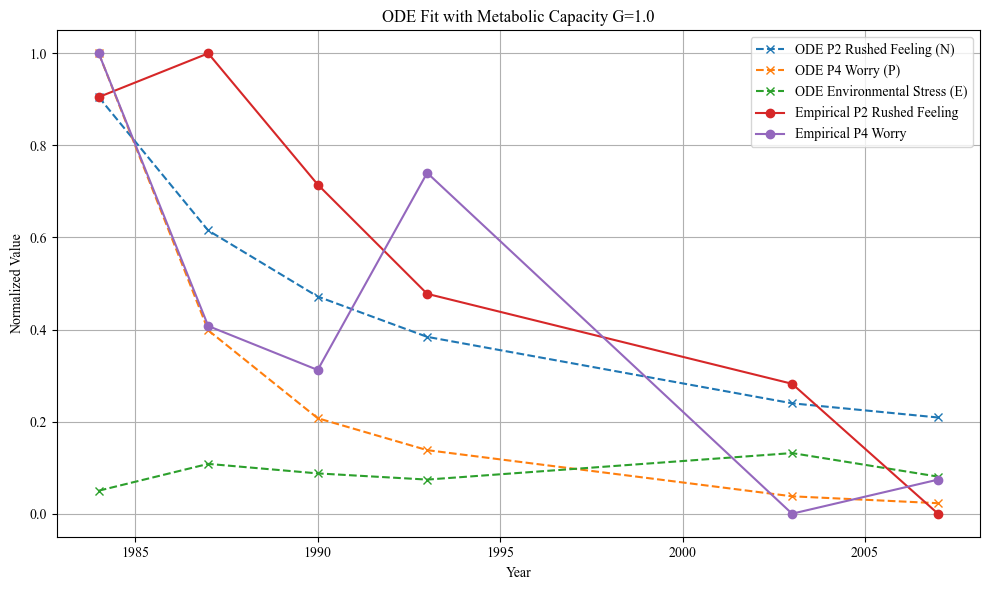

In [134]:
# Associated with 'Figure 20' in Appendix C.5, in arXiv:2506.20622
#
# APPENDIX C.5: Metabolic Capacity Sensitivity Sweep
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# === Trait Entropy Data ===
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023],
}

df = pd.DataFrame(data)
trait_x = "P2 Rushed Feeling"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# === Updated ODE System with metabolic capacity G ===
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K, G):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * (E_dynamic / G)
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# === Parameters ===
mu    = 0.00001
alpha = 0.15
beta  = 0.16746
gamma = 0.03
c1    = 2.0
c2    = 0.21
c3    = 5.60
K     = 0.5
G     = 1.0  # Can be varied for testing metabolic constraint

# === Initial Conditions and Simulation ===
init_conditions = [N_empirical[0], P_empirical[0], 0.05]
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K, G))
N_model, P_model, E_model = sol.T

# === Metrics ===
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)
rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)

# === DTW Function ===
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"Parameters: mu={mu}, alpha ={alpha} , beta={beta}, gamma={gamma}, c1={c1}, c2={c2}, c3={c3}, K={K}, G={G}")
print(f"RMSE: {trait_x}={rmse_N:.4f}, {trait_y}={rmse_P:.4f}")
print(f"R²: {trait_x}={r2_N:.4f}, {trait_y}={r2_P:.4f}")
print(f"Pearson r: {trait_x}={rN:.3f} (p={pN:.3f}), {trait_y}={rP:.3f} (p={pP:.3f})")
print(f"DTW distance: {trait_x}={dtwN:.3f}, {trait_y}={dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit with Metabolic Capacity G={G}")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Parameters: mu=1e-05, alpha=0.15, beta=0.16746, gamma=0.03, c1=2.0, c2=0.21, c3=5.6, K=0.5, G=0.12
RMSE: P2 Rushed Feeling=0.1982, P4 Worry=0.3653
R²: P2 Rushed Feeling=0.6789, P4 Worry=-0.0718
Pearson r: P2 Rushed Feeling=0.879 (p=0.021), P4 Worry=0.735 (p=0.096)
DTW distance: P2 Rushed Feeling=0.514, P4 Worry=1.475


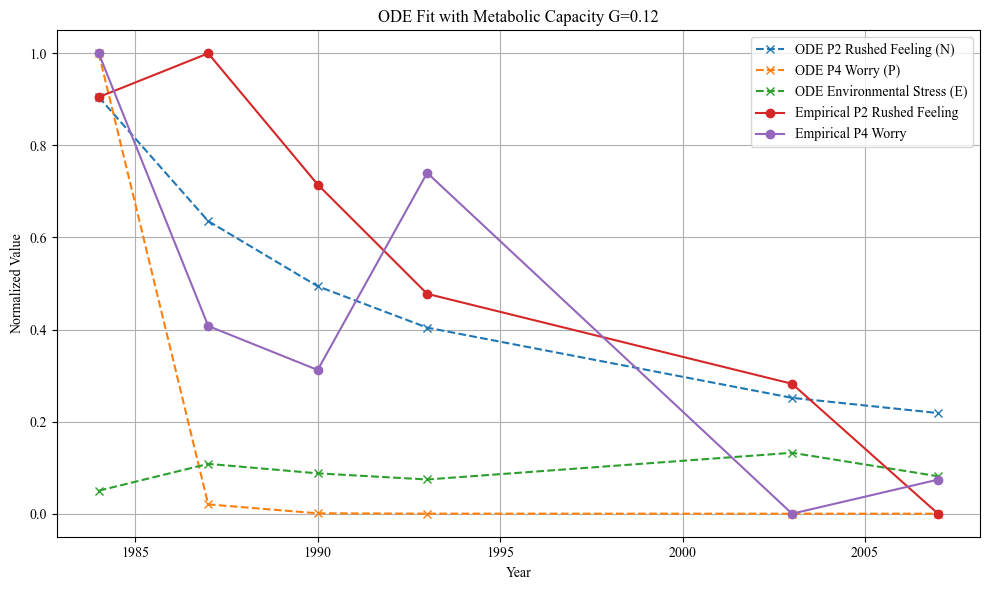

In [136]:
# Associated with 'Figure 21' in Appendix C.5, in arXiv:2506.20622
#
# APPENDIX C.5: Metabolic Capacity Sensitivity Sweep
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# === Trait Entropy Data ===
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023],
}

df = pd.DataFrame(data)
trait_x = "P2 Rushed Feeling"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# === Updated ODE System with metabolic capacity G ===
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K, G):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * (E_dynamic / G)
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# === Parameters ===
mu    = 0.00001
alpha = 0.15
beta  = 0.16746
gamma = 0.03
c1    = 2.0
c2    = 0.21
c3    = 5.60
K     = 0.5
G     = 0.120  # Can be varied for testing metabolic constraint

# === Initial Conditions and Simulation ===
init_conditions = [N_empirical[0], P_empirical[0], 0.05]
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K, G))
N_model, P_model, E_model = sol.T

# === Metrics ===
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)
rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)

# === DTW Function ===
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"Parameters: mu={mu}, alpha={alpha}, beta={beta}, gamma={gamma}, c1={c1}, c2={c2}, c3={c3}, K={K}, G={G}")
print(f"RMSE: {trait_x}={rmse_N:.4f}, {trait_y}={rmse_P:.4f}")
print(f"R²: {trait_x}={r2_N:.4f}, {trait_y}={r2_P:.4f}")
print(f"Pearson r: {trait_x}={rN:.3f} (p={pN:.3f}), {trait_y}={rP:.3f} (p={pP:.3f})")
print(f"DTW distance: {trait_x}={dtwN:.3f}, {trait_y}={dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit with Metabolic Capacity G={G}")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Parameters: mu=1e-05, alpha=0.15, beta=0.16746, gamma=0.03, c1=2.0, c2=0.21, c3=5.6, K=0.5, G=0.48
RMSE: P2 Rushed Feeling=0.2044, P4 Worry=0.3136
R²: P2 Rushed Feeling=0.6584, P4 Worry=0.2100
Pearson r: P2 Rushed Feeling=0.870 (p=0.024), P4 Worry=0.768 (p=0.075)
DTW distance: P2 Rushed Feeling=0.525, P4 Worry=1.022


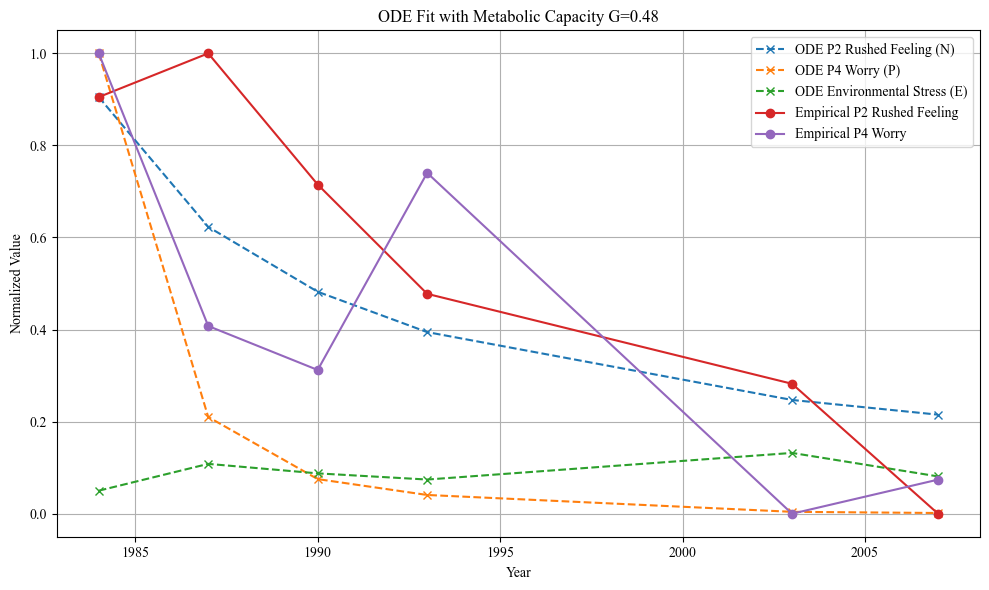

In [138]:
# Associated with 'Figure 22' in Appendix C.5, in arXiv:2506.20622
#
# APPENDIX C.5: Metabolic Capacity Sensitivity Sweep
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# === Trait Entropy Data ===
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023],
}

df = pd.DataFrame(data)
trait_x = "P2 Rushed Feeling"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# === Updated ODE System with metabolic capacity G ===
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K, G):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * (E_dynamic / G)
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# === Parameters ===
mu    = 0.00001
alpha = 0.15
beta  = 0.16746
gamma = 0.03
c1    = 2.0
c2    = 0.21
c3    = 5.60
K     = 0.5
G     = 0.480  # Can be varied for testing metabolic constraint

# === Initial Conditions and Simulation ===
init_conditions = [N_empirical[0], P_empirical[0], 0.05]
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K, G))
N_model, P_model, E_model = sol.T

# === Metrics ===
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)
rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)

# === DTW Function ===
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"Parameters: mu={mu}, alpha={alpha}, beta={beta}, gamma={gamma}, c1={c1}, c2={c2}, c3={c3}, K={K}, G={G}")
print(f"RMSE: {trait_x}={rmse_N:.4f}, {trait_y}={rmse_P:.4f}")
print(f"R²: {trait_x}={r2_N:.4f}, {trait_y}={r2_P:.4f}")
print(f"Pearson r: {trait_x}={rN:.3f} (p={pN:.3f}), {trait_y}={rP:.3f} (p={pP:.3f})")
print(f"DTW distance: {trait_x}={dtwN:.3f}, {trait_y}={dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit with Metabolic Capacity G={G}")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Parameters: mu=1e-05, alpha=0.15 beta=0.16746, gamma=0.03, c1=2.0, c2=0.21, c3=5.6, K=0.5, G=0.95
RMSE: P2 Rushed Feeling=0.2085, P4 Worry=0.2556
R²: P2 Rushed Feeling=0.6449, P4 Worry=0.4753
Pearson r: P2 Rushed Feeling=0.865 (p=0.026), P4 Worry=0.797 (p=0.058)
DTW distance: P2 Rushed Feeling=0.543, P4 Worry=0.797


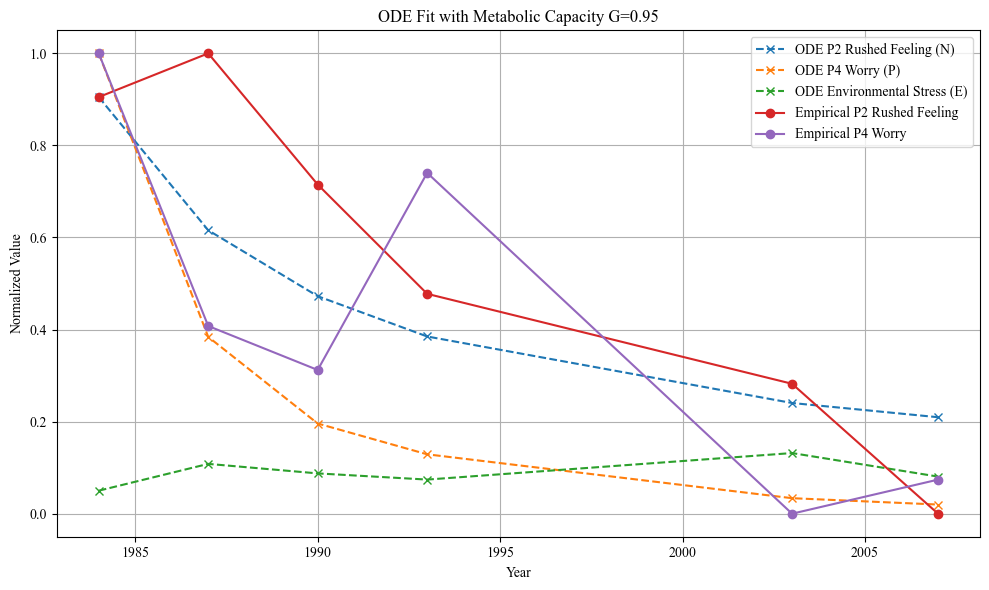

In [140]:
# Associated with 'Figure 23' in Appendix C.5, in arXiv:2506.20622
#
# APPENDIX C.5: Metabolic Capacity Sensitivity Sweep
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# === Trait Entropy Data ===
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023],
}

df = pd.DataFrame(data)
trait_x = "P2 Rushed Feeling"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# === Updated ODE System with metabolic capacity G ===
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K, G):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * (E_dynamic / G)
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# === Parameters ===
mu    = 0.00001
alpha = 0.15
beta  = 0.16746
gamma = 0.03
c1    = 2.0
c2    = 0.21
c3    = 5.60
K     = 0.5
G     = 0.950  # Can be varied for testing metabolic constraint

# === Initial Conditions and Simulation ===
init_conditions = [N_empirical[0], P_empirical[0], 0.05]
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K, G))
N_model, P_model, E_model = sol.T

# === Metrics ===
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)
rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)

# === DTW Function ===
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"Parameters: mu={mu}, alpha={alpha} beta={beta}, gamma={gamma}, c1={c1}, c2={c2}, c3={c3}, K={K}, G={G}")
print(f"RMSE: {trait_x}={rmse_N:.4f}, {trait_y}={rmse_P:.4f}")
print(f"R²: {trait_x}={r2_N:.4f}, {trait_y}={r2_P:.4f}")
print(f"Pearson r: {trait_x}={rN:.3f} (p={pN:.3f}), {trait_y}={rP:.3f} (p={pP:.3f})")
print(f"DTW distance: {trait_x}={dtwN:.3f}, {trait_y}={dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit with Metabolic Capacity G={G}")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Parameters: mu=1e-05, alpha =0.15, beta=0.16746, gamma=0.03, c1=2.0, c2=0.21, c3=5.6, K=0.5, G=1.48
RMSE: P2 Rushed Feeling=0.2109, P4 Worry=0.2197
R²: P2 Rushed Feeling=0.6364, P4 Worry=0.6121
Pearson r: P2 Rushed Feeling=0.863 (p=0.027), P4 Worry=0.809 (p=0.051)
DTW distance: P2 Rushed Feeling=0.558, P4 Worry=0.729


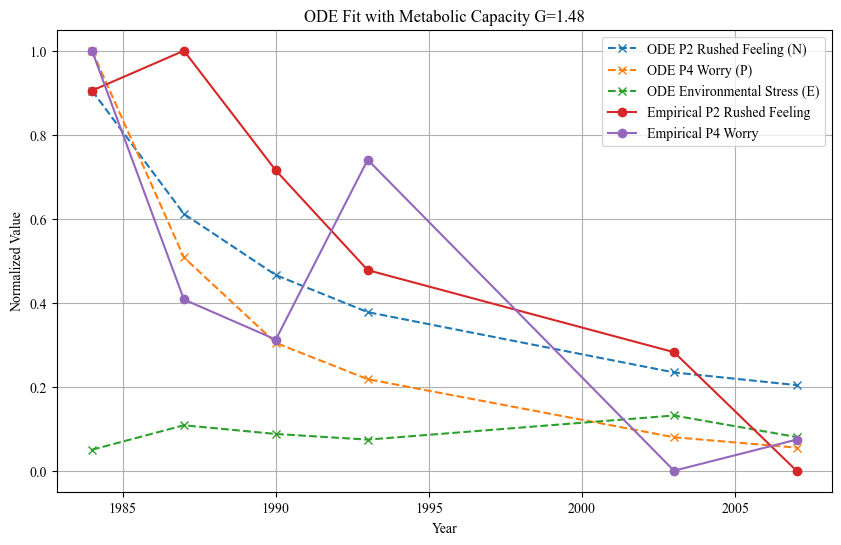

In [142]:
# Associated with 'Figure 24' in Appendix C.5, in arXiv:2506.20622
#
# APPENDIX C.5: Metabolic Capacity Sensitivity Sweep
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# === Trait Entropy Data ===
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "P9 Satisfaction": [2.0260, 1.9559, 1.9783, 1.9952, 1.7102, 1.7284],
    "L10 Fulfillment": [2.2521, 2.1900, 2.1779, 2.1668, 2.1250, 2.1041],
    "P4 Worry": [2.2142, 2.1590, 2.1501, 2.1900, 2.1210, 2.1279],
    "P8 Hot-Tempered": [2.0755, 2.0014, 2.0219, 1.9978, 1.8980, 1.9556],
    "P11 Indignant": [2.2481, 2.2181, 2.2193, 2.2374, 2.2025, 2.1867],
    "L11 Depressed": [1.9549, 1.8902, 1.9110, 1.9503, 1.8526, 1.8764],
    "N49 Curiosity": [2.2429, 2.2265, 2.2022, 2.2113, 2.1799, 2.1501],
    "S28 Excitement Preference": [2.2402, 2.1675, 2.1284, 2.1266, 2.0950, 2.0190],
    "I8 Impulsivity": [2.1984, 2.1799, 2.1970, 2.2063, 2.1483, 2.1020],
    "A1 Competitive Ambition": [1.9748, 1.8601, 1.9016, 1.9649, 1.9649, 1.9936],
    "L1 Life Optimism": [2.1659, 2.0975, 2.0527, 2.0287, 1.9884, 1.9931],
    "P2 Rushed Feeling": [2.2690, 2.2760, 2.2550, 2.2375, 2.2231, 2.2023],
}

df = pd.DataFrame(data)
trait_x = "P2 Rushed Feeling"
trait_y = "P4 Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# === Updated ODE System with metabolic capacity G ===
def system(y, t, mu, alpha, beta, gamma, c1, c2, c3, K, G):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - alpha * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * (E_dynamic / G)
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# === Parameters ===
mu    = 0.00001
alpha = 0.15
beta  = 0.16746
gamma = 0.03
c1    = 2.0
c2    = 0.21
c3    = 5.60
K     = 0.5
G     = 1.480  # Can be varied for testing metabolic constraint

# === Initial Conditions and Simulation ===
init_conditions = [N_empirical[0], P_empirical[0], 0.05]
sol = odeint(system, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K, G))
N_model, P_model, E_model = sol.T

# === Metrics ===
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)
rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)

# === DTW Function ===
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"Parameters: mu={mu}, alpha ={alpha}, beta={beta}, gamma={gamma}, c1={c1}, c2={c2}, c3={c3}, K={K}, G={G}")
print(f"RMSE: {trait_x}={rmse_N:.4f}, {trait_y}={rmse_P:.4f}")
print(f"R²: {trait_x}={r2_N:.4f}, {trait_y}={r2_P:.4f}")
print(f"Pearson r: {trait_x}={rN:.3f} (p={pN:.3f}), {trait_y}={rP:.3f} (p={pP:.3f})")
print(f"DTW distance: {trait_x}={dtwN:.3f}, {trait_y}={dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit with Metabolic Capacity G={G}")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()
